<a href="https://colab.research.google.com/github/MariiaKalinina/BM/blob/main/BM_initial_10_layer_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from math import *
from scipy.special import lambertw
import matplotlib.pyplot as plt

In [2]:
!pip install GitPython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.4 MB/s eta 0:00:00


In [3]:
from git import Repo
!git clone https://github.com/MariiaKalinina/BM.git

Cloning into 'BM'...
remote: Enumerating objects: 382, done.
remote: Counting objects: 100% (259/259), done.
remote: Compressing objects: 100% (186/186), done.
remote: Total 382 (delta 150), reused 128 (delta 71), pack-reused 123
Receiving objects: 100% (382/382), 21.85 MiB | 14.73 MiB/s, done.
Resolving deltas: 100% (226/226), done.


### Step 0. Data preparation

In [59]:
# import pandas as pd

df_constast = pd.read_csv('/content/BM/Initial data/Constants.csv', delimiter=';', header=0)
df_well = pd.read_csv('/content/BM/Initial data/Well_parametrs.csv', delimiter=';', header=0)

# df_well = pd.read_csv('/content/Well_parametrs_v1.csv', delimiter=';', header=0) ### пример для 3х слойной модели
# df_well = pd.read_csv('/content/BM/Well_parametrs_A13.csv', delimiter=';', header=0) ### Geoterm test - Appendix 13

df_well[['Depth top, m', 'Depth bottom, m']] = df_well[['Depth top, m', 'Depth bottom, m']].apply(lambda x: x / 1000)

In [60]:
df_well

Well Event_name  Event_type Lithology_type  Age (Ma)  Depth top, m  \
0   Test_well    Erosion     Erosion            NaN         0          0.00   
1   Test_well   Layer 10     Erosion         Shales         0          0.00   
2   Test_well    Layer 9  Deposition     Sandstones        45          0.20   
3   Test_well    Layer 8  Deposition         Shales        55          0.45   
4   Test_well    Layer 7  Deposition          Chalk        80          1.20   
5   Test_well    Layer 6  Deposition     Sandstones       100          2.50   
6   Test_well    Layer 5  Deposition     Limestones       125          3.40   
7   Test_well    Layer 4  Deposition       Dolomite       145          3.60   
8   Test_well    Layer 3  Deposition     Sandstones       160          4.00   
9   Test_well    Layer 2  Deposition      Anhydrite       210          4.25   
10  Test_well    Layer 1  Deposition      Quartzite       245          5.00   
11  Test_well  Fundament  Deposition            NaN       260          5.40   

    Depth bottom, m  Thickness, m  D Thickness (erosion), m  \
0              0.00             0                       NaN   
1              0.20           200                       NaN   
2              0.45           250                       NaN   
3              1.20           750                       NaN   
4              2.50          1300                       NaN   
5              3.40           900                       NaN   
6              3.60           200                       NaN   
7              4.00           400                       NaN   
8              4.25           250                       NaN   
9              5.00           750                       NaN   
10             5.40           400                       NaN   
11             5.40             0                       NaN   

    Paleobathymetry, Ma  Sea level, m Sublayers  N sublayers        PSE  \
0                   300             0       NaN          NaN        NaN   
1                   300             0        On          5.0        NaN   
2                   325            40        On          5.0        NaN   
3                   350            50        On          5.0  Reservoir   
4                   300           100        On          5.0        NaN   
5                   200            80        On          5.0        NaN   
6                    20            70        On          5.0        NaN   
7                    20           -40        On          5.0  Reservoir   
8                    10           -20        On          5.0        NaN   
9                    20             0        On          5.0        NaN   
10                    0             0        On          5.0        NaN   
11                  -20            10       NaN          NaN        NaN   

    Kinetic  TOC initial, %  HI initial, %  
0       NaN             NaN            NaN  
1       NaN             NaN            NaN  
2       NaN             NaN            NaN  
3       NaN             NaN            NaN  
4       NaN             NaN            NaN  
5       NaN             NaN            NaN  
6       NaN             NaN            NaN  
7       NaN             NaN            NaN  
8       NaN             NaN            NaN  
9       NaN             NaN            NaN  
10      NaN             NaN            NaN  
11      NaN             NaN            NaN

In [61]:
df_constast

Lithology_type  Porosity  Exp_decay, km-1  Grain density  TC matrix  \
0         Shales      0.63             0.51           2720        2.0   
1     Sandstones      0.49             0.27           2650        5.5   
2          Chalk      0.70             0.71           2710        3.3   
3     Limestones      0.40             0.60           2710        3.3   
4       Dolomite      0.20             0.60           2870        5.3   
5      Anhydrite      0.05             0.20           2960        6.3   
6      Quartzite      0.20             0.30           2650        7.7   
7      Fundament      0.00             0.00           2800        3.0   

   Radiogenic Heat Production  Ki_framework  
0                1.700000e-06           2.0  
1                1.200000e-06           5.5  
2                4.000000e-07           3.3  
3                5.000000e-07           3.3  
4                4.000000e-07           5.3  
5                1.000000e-07           6.3  
6                5.000000e-07           7.7  
7                2.800000e-06           3.0

In [62]:
# Кол-во слоев по которым будет проходит расчет.
# Не учитывает первый слой - Эрозию и последний - Фундамент
layers_quantity = len(df_well[1:df_well.shape[0]-1]) #amount of layers for calculation
layers_quantity

10

In [63]:
work_layers = df_well[1:df_well.shape[0]-1] ### Слои, по которым идет расчет
work_layers

Well Event_name  Event_type Lithology_type  Age (Ma)  Depth top, m  \
1   Test_well   Layer 10     Erosion         Shales         0          0.00   
2   Test_well    Layer 9  Deposition     Sandstones        45          0.20   
3   Test_well    Layer 8  Deposition         Shales        55          0.45   
4   Test_well    Layer 7  Deposition          Chalk        80          1.20   
5   Test_well    Layer 6  Deposition     Sandstones       100          2.50   
6   Test_well    Layer 5  Deposition     Limestones       125          3.40   
7   Test_well    Layer 4  Deposition       Dolomite       145          3.60   
8   Test_well    Layer 3  Deposition     Sandstones       160          4.00   
9   Test_well    Layer 2  Deposition      Anhydrite       210          4.25   
10  Test_well    Layer 1  Deposition      Quartzite       245          5.00   

    Depth bottom, m  Thickness, m  D Thickness (erosion), m  \
1              0.20           200                       NaN   
2              0.45           250                       NaN   
3              1.20           750                       NaN   
4              2.50          1300                       NaN   
5              3.40           900                       NaN   
6              3.60           200                       NaN   
7              4.00           400                       NaN   
8              4.25           250                       NaN   
9              5.00           750                       NaN   
10             5.40           400                       NaN   

    Paleobathymetry, Ma  Sea level, m Sublayers  N sublayers        PSE  \
1                   300             0        On          5.0        NaN   
2                   325            40        On          5.0        NaN   
3                   350            50        On          5.0  Reservoir   
4                   300           100        On          5.0        NaN   
5                   200            80        On          5.0        NaN   
6                    20            70        On          5.0        NaN   
7                    20           -40        On          5.0  Reservoir   
8                    10           -20        On          5.0        NaN   
9                    20             0        On          5.0        NaN   
10                    0             0        On          5.0        NaN   

    Kinetic  TOC initial, %  HI initial, %  
1       NaN             NaN            NaN  
2       NaN             NaN            NaN  
3       NaN             NaN            NaN  
4       NaN             NaN            NaN  
5       NaN             NaN            NaN  
6       NaN             NaN            NaN  
7       NaN             NaN            NaN  
8       NaN             NaN            NaN  
9       NaN             NaN            NaN  
10      NaN             NaN            NaN

In [9]:
# filtered_df = df_well[df_well['Event_name'] != 'Erosion']

In [10]:
df_well.iloc[-1]

Well                         Test_well
Event_name                   Fundament
Event_type                  Deposition
Lithology_type                     NaN
Age (Ma)                           260
Depth top, m                       5.4
Depth bottom, m                    5.4
Thickness, m                         0
D Thickness (erosion), m           NaN
Paleobathymetry, Ma                -20
Sea level, m                        10
Sublayers                          NaN
N sublayers                        NaN
PSE                                NaN
Kinetic                            NaN
TOC initial, %                     NaN
HI initial, %                      NaN
Name: 11, dtype: object

### Layers Subdivision

In [64]:
def layers_subdivision(work_layers, on=True):

  df_repeated = pd.DataFrame()

  if on == False:
    return work_layers
  else:

    result_df = pd.DataFrame()
    work_layers_copy = work_layers[0:].copy()
    # Python (Pandas)
    for index, row in work_layers_copy.iterrows():
        if not pd.isnull(row['N sublayers']):
            # Calculate the interval value
            interval = (row['Depth bottom, m'] - row['Depth top, m']) / int(row['N sublayers'])
            interval_thickness = row['Thickness, m'] / (int(row['N sublayers']))

            interval_age = 0
            next_index = index + 1
            if next_index < len(work_layers_copy):
              next_row = work_layers_copy.loc[next_index]
              interval_age = (next_row['Age (Ma)'] - row['Age (Ma)']) / (int(row['N sublayers']))
            else:
              last_row= df_well.iloc[-1]
              next_row = last_row
              interval_age = (next_row['Age (Ma)'] - row['Age (Ma)']) / (int(row['N sublayers']))

            # Repeat the row 'div' times and append to the new DataFrame
            repeated_rows = [row.copy() for _ in range(int(row['N sublayers']))]
            for i, r in enumerate(repeated_rows):
                r['Event_name'] = row['Event_name'] + f'_{i+1}'
                r['Depth top, m'] = row['Depth top, m'] + i * interval
                r['Depth bottom, m'] = row['Depth top, m'] + (i + 1) * interval
                r['Thickness, m'] = interval_thickness
                r['Age (Ma)'] = row['Age (Ma)'] + i*interval_age
            df_repeated = pd.concat([df_repeated, pd.DataFrame(repeated_rows)], ignore_index=True)
        else:
            df_repeated = pd.concat([df_repeated, pd.DataFrame([row])], ignore_index=True)

    return df_repeated

In [65]:
work_layers = layers_subdivision(work_layers, on=True)
###
  # on = True make subdivision
###

In [66]:
work_layers

Well  Event_name  Event_type Lithology_type  Age (Ma)  Depth top, m  \
0   Test_well  Layer 10_1     Erosion         Shales       0.0          0.00   
1   Test_well  Layer 10_2     Erosion         Shales       9.0          0.04   
2   Test_well  Layer 10_3     Erosion         Shales      18.0          0.08   
3   Test_well  Layer 10_4     Erosion         Shales      27.0          0.12   
4   Test_well  Layer 10_5     Erosion         Shales      36.0          0.16   
5   Test_well   Layer 9_1  Deposition     Sandstones      45.0          0.20   
6   Test_well   Layer 9_2  Deposition     Sandstones      47.0          0.25   
7   Test_well   Layer 9_3  Deposition     Sandstones      49.0          0.30   
8   Test_well   Layer 9_4  Deposition     Sandstones      51.0          0.35   
9   Test_well   Layer 9_5  Deposition     Sandstones      53.0          0.40   
10  Test_well   Layer 8_1  Deposition         Shales      55.0          0.45   
11  Test_well   Layer 8_2  Deposition         Shales      60.0          0.60   
12  Test_well   Layer 8_3  Deposition         Shales      65.0          0.75   
13  Test_well   Layer 8_4  Deposition         Shales      70.0          0.90   
14  Test_well   Layer 8_5  Deposition         Shales      75.0          1.05   
15  Test_well   Layer 7_1  Deposition          Chalk      80.0          1.20   
16  Test_well   Layer 7_2  Deposition          Chalk      84.0          1.46   
17  Test_well   Layer 7_3  Deposition          Chalk      88.0          1.72   
18  Test_well   Layer 7_4  Deposition          Chalk      92.0          1.98   
19  Test_well   Layer 7_5  Deposition          Chalk      96.0          2.24   
20  Test_well   Layer 6_1  Deposition     Sandstones     100.0          2.50   
21  Test_well   Layer 6_2  Deposition     Sandstones     105.0          2.68   
22  Test_well   Layer 6_3  Deposition     Sandstones     110.0          2.86   
23  Test_well   Layer 6_4  Deposition     Sandstones     115.0          3.04   
24  Test_well   Layer 6_5  Deposition     Sandstones     120.0          3.22   
25  Test_well   Layer 5_1  Deposition     Limestones     125.0          3.40   
26  Test_well   Layer 5_2  Deposition     Limestones     129.0          3.44   
27  Test_well   Layer 5_3  Deposition     Limestones     133.0          3.48   
28  Test_well   Layer 5_4  Deposition     Limestones     137.0          3.52   
29  Test_well   Layer 5_5  Deposition     Limestones     141.0          3.56   
30  Test_well   Layer 4_1  Deposition       Dolomite     145.0          3.60   
31  Test_well   Layer 4_2  Deposition       Dolomite     148.0          3.68   
32  Test_well   Layer 4_3  Deposition       Dolomite     151.0          3.76   
33  Test_well   Layer 4_4  Deposition       Dolomite     154.0          3.84   
34  Test_well   Layer 4_5  Deposition       Dolomite     157.0          3.92   
35  Test_well   Layer 3_1  Deposition     Sandstones     160.0          4.00   
36  Test_well   Layer 3_2  Deposition     Sandstones     170.0          4.05   
37  Test_well   Layer 3_3  Deposition     Sandstones     180.0          4.10   
38  Test_well   Layer 3_4  Deposition     Sandstones     190.0          4.15   
39  Test_well   Layer 3_5  Deposition     Sandstones     200.0          4.20   
40  Test_well   Layer 2_1  Deposition      Anhydrite     210.0          4.25   
41  Test_well   Layer 2_2  Deposition      Anhydrite     220.0          4.40   
42  Test_well   Layer 2_3  Deposition      Anhydrite     230.0          4.55   
43  Test_well   Layer 2_4  Deposition      Anhydrite     240.0          4.70   
44  Test_well   Layer 2_5  Deposition      Anhydrite     250.0          4.85   
45  Test_well   Layer 1_1  Deposition      Quartzite     245.0          5.00   
46  Test_well   Layer 1_2  Deposition      Quartzite     248.0          5.08   
47  Test_well   Layer 1_3  Deposition      Quartzite     251.0          5.16   
48  Test_well   Layer 1_4  Deposition      Quartzite     254.0          5.24   
49  Test_

### Lithology

In [67]:
lithology_numbers = {30000: {'lith':'Sandstones', 'lith_num':1, 'hatch': '..', 'color':'#ffff00'},
                 65030: {'lith':'Sandstone/Shale', 'lith_num':2, 'hatch':'-.', 'color':'#ffe119'},
                 65000: {'lith':'Shales', 'lith_num':3, 'hatch':'--', 'color':'#bebebe'},
                 80000: {'lith':'Marl', 'lith_num':4, 'hatch':'', 'color':'#7cfc00'},
                 74000: {'lith':'Dolomite', 'lith_num':5, 'hatch':'-/', 'color':'#8080ff'},
                 70000: {'lith':'Limestones', 'lith_num':6, 'hatch':'+', 'color':'#80ffff'},
                 70032: {'lith':'Chalk', 'lith_num':7, 'hatch':'..', 'color':'#80ffff'},
                 88000: {'lith':'Halite', 'lith_num':8, 'hatch':'x', 'color':'#7ddfbe'},
                 86000: {'lith':'Anhydrite', 'lith_num':9, 'hatch':'', 'color':'#ff80ff'},
                 99000: {'lith':'Tuff', 'lith_num':10, 'hatch':'||', 'color':'#ff8c00'},
                 90000: {'lith':'Quartzite', 'lith_num':11, 'hatch':'', 'color':'black'},
                 93000: {'lith':'Basement', 'lith_num':12, 'hatch':'-|', 'color':'#ef138a'}}

In [68]:
df_lith = pd.DataFrame.from_dict(lithology_numbers, orient='index')
df_lith.reset_index(inplace=True)
df_lith

index             lith  lith_num hatch    color
0   30000       Sandstones         1    ..  #ffff00
1   65030  Sandstone/Shale         2    -.  #ffe119
2   65000           Shales         3    --  #bebebe
3   80000             Marl         4        #7cfc00
4   74000         Dolomite         5    -/  #8080ff
5   70000       Limestones         6     +  #80ffff
6   70032            Chalk         7    ..  #80ffff
7   88000           Halite         8     x  #7ddfbe
8   86000        Anhydrite         9        #ff80ff
9   99000             Tuff        10    ||  #ff8c00
10  90000        Quartzite        11          black
11  93000         Basement        12    -|  #ef138a

In [69]:
lithology_array = []
hatch_array = []
color_array = []

for row_index, row in enumerate(work_layers.itertuples()):

    lithology = work_layers.at[row.Index, 'Lithology_type']
    layers_name = work_layers.at[row.Index, 'Event_name']
    # print(lithology)

    lit_num = df_lith.loc[df_lith['lith'] == str(lithology), 'index'].iloc[0]
    lithology_array.append(lit_num)


    hatch_val = df_lith.loc[df_lith['lith'] == str(lithology), 'hatch'].iloc[0]
    hatch_array.append(hatch_val)

    color_val = df_lith.loc[df_lith['lith'] == str(lithology), 'color'].iloc[0]
    color_array.append(color_val)

work_layers["Lithology"] = lithology_array
work_layers["Index"] = hatch_array
work_layers["Color"] = color_array
work_layers_with_color = work_layers.copy()
work_layers

Well  Event_name  Event_type Lithology_type  Age (Ma)  Depth top, m  \
0   Test_well  Layer 10_1     Erosion         Shales       0.0          0.00   
1   Test_well  Layer 10_2     Erosion         Shales       9.0          0.04   
2   Test_well  Layer 10_3     Erosion         Shales      18.0          0.08   
3   Test_well  Layer 10_4     Erosion         Shales      27.0          0.12   
4   Test_well  Layer 10_5     Erosion         Shales      36.0          0.16   
5   Test_well   Layer 9_1  Deposition     Sandstones      45.0          0.20   
6   Test_well   Layer 9_2  Deposition     Sandstones      47.0          0.25   
7   Test_well   Layer 9_3  Deposition     Sandstones      49.0          0.30   
8   Test_well   Layer 9_4  Deposition     Sandstones      51.0          0.35   
9   Test_well   Layer 9_5  Deposition     Sandstones      53.0          0.40   
10  Test_well   Layer 8_1  Deposition         Shales      55.0          0.45   
11  Test_well   Layer 8_2  Deposition         Shales      60.0          0.60   
12  Test_well   Layer 8_3  Deposition         Shales      65.0          0.75   
13  Test_well   Layer 8_4  Deposition         Shales      70.0          0.90   
14  Test_well   Layer 8_5  Deposition         Shales      75.0          1.05   
15  Test_well   Layer 7_1  Deposition          Chalk      80.0          1.20   
16  Test_well   Layer 7_2  Deposition          Chalk      84.0          1.46   
17  Test_well   Layer 7_3  Deposition          Chalk      88.0          1.72   
18  Test_well   Layer 7_4  Deposition          Chalk      92.0          1.98   
19  Test_well   Layer 7_5  Deposition          Chalk      96.0          2.24   
20  Test_well   Layer 6_1  Deposition     Sandstones     100.0          2.50   
21  Test_well   Layer 6_2  Deposition     Sandstones     105.0          2.68   
22  Test_well   Layer 6_3  Deposition     Sandstones     110.0          2.86   
23  Test_well   Layer 6_4  Deposition     Sandstones     115.0          3.04   
24  Test_well   Layer 6_5  Deposition     Sandstones     120.0          3.22   
25  Test_well   Layer 5_1  Deposition     Limestones     125.0          3.40   
26  Test_well   Layer 5_2  Deposition     Limestones     129.0          3.44   
27  Test_well   Layer 5_3  Deposition     Limestones     133.0          3.48   
28  Test_well   Layer 5_4  Deposition     Limestones     137.0          3.52   
29  Test_well   Layer 5_5  Deposition     Limestones     141.0          3.56   
30  Test_well   Layer 4_1  Deposition       Dolomite     145.0          3.60   
31  Test_well   Layer 4_2  Deposition       Dolomite     148.0          3.68   
32  Test_well   Layer 4_3  Deposition       Dolomite     151.0          3.76   
33  Test_well   Layer 4_4  Deposition       Dolomite     154.0          3.84   
34  Test_well   Layer 4_5  Deposition       Dolomite     157.0          3.92   
35  Test_well   Layer 3_1  Deposition     Sandstones     160.0          4.00   
36  Test_well   Layer 3_2  Deposition     Sandstones     170.0          4.05   
37  Test_well   Layer 3_3  Deposition     Sandstones     180.0          4.10   
38  Test_well   Layer 3_4  Deposition     Sandstones     190.0          4.15   
39  Test_well   Layer 3_5  Deposition     Sandstones     200.0          4.20   
40  Test_well   Layer 2_1  Deposition      Anhydrite     210.0          4.25   
41  Test_well   Layer 2_2  Deposition      Anhydrite     220.0          4.40   
42  Test_well   Layer 2_3  Deposition      Anhydrite     230.0          4.55   
43  Test_well   Layer 2_4  Deposition      Anhydrite     240.0          4.70   
44  Test_well   Layer 2_5  Deposition      Anhydrite     250.0          4.85   
45  Test_well   Layer 1_1  Deposition      Quartzite     245.0          5.00   
46  Test_well   Layer 1_2  Deposition      Quartzite     248.0          5.08   
47  Test_well   Layer 1_3  Deposition      Quartzite     251.0          5.16   
48  Test_well   Layer 1_4  Deposition      Quartzite     254.0          5.24   
49  Test_

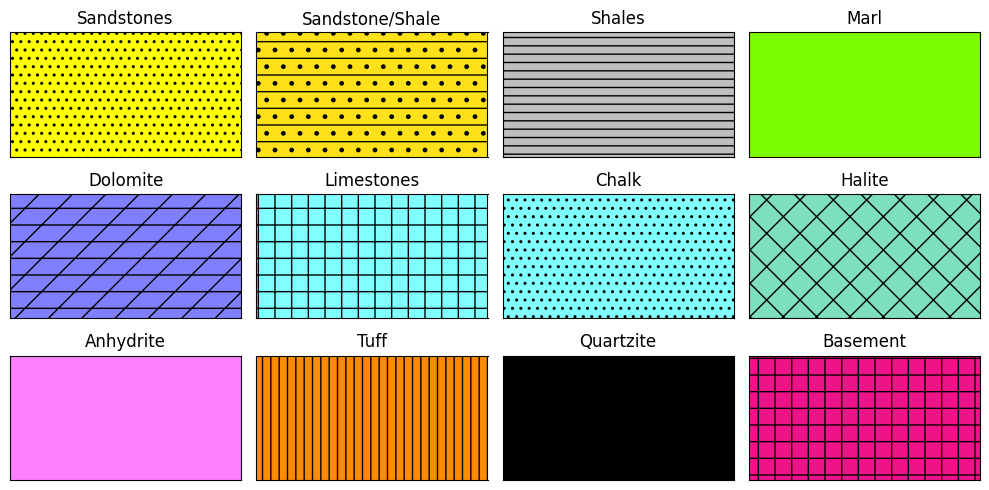

In [17]:
y = [0, 1]
x = [1, 1]

fig, axes = plt.subplots(ncols=4,nrows=3, sharex=True, sharey=True,
                         figsize=(10,5), subplot_kw={'xticks': [], 'yticks': []})

for ax, key in zip(axes.flat, lithology_numbers.keys()):
    ax.plot(x, y)
    ax.fill_betweenx(y, 0, 1, facecolor=lithology_numbers[key]['color'], hatch=lithology_numbers[key]['hatch'])
    ax.set_xlim(0, 0.1)
    ax.set_ylim(0, 1)
    ax.set_title(str(lithology_numbers[key]['lith']))

plt.tight_layout()

plt.show()

### Step 1, 2, 3

Step 1. Decompaction (decompacted thickness).

Step 2. Correction for paleobathymetry and eustasy (Decompacted depth with corrction).

Step 3. Removal effect of sediment load (porosity, density).



In [18]:
def decomp_func(y1, y2, y1_d, phi, c):  # возвращает фун-ию одной переменной, для которой затем подбирается параметр y2_d

    y2_d = (np.exp(-np.log(e) * y1_d * c) * phi * np.log(e) - \
            np.exp(-np.log(e) * y1 * c) * phi * np.log(e) + \
            np.exp(-np.log(e) * y2 * c) * phi * np.log(e) - \
            np.log(e) * y1 * c + np.log(e) * y1_d * c + np.log(e) * y2 * c + \
            lambertw(-np.log(e) * phi * np.exp(-np.exp(-np.log(e) * y1_d * c) * phi * np.log(e) +\
                                               np.exp(-np.log(e) * y1 * c) * phi * np.log(e) - \
                                               np.exp(-np.log(e) * y2 * c) * phi * np.log(e) + \
                                               np.log(e) * y1 * c - \
                                               np.log(e) * y1_d * c - np.log(e) * y2 * c))) / c / np.log(e)
    return y2_d.real

In [19]:
#считает скорректированную декомпактированную глубину
def corrected(depth, RoMantle, RoWater, sea_level, sea_level_today):
  return depth - sea_level_today * (RoWater / (RoMantle - RoWater)) + (sea_level - sea_level_today)

In [20]:
### the averaeg porosity of a stratigraphic unit at any depth [A.58.6]
def porosity_func(surface_porosity, exp_decay, y1, y2, thicknesses):
  return surface_porosity/exp_decay*((np.exp(-exp_decay*y1) - np.exp(-exp_decay*y2))/thicknesses)

In [21]:
def bulk_density(porosity, RoGrain, RoWater):
  return porosity*RoWater + (1-porosity)*RoGrain

In [22]:
def bulk_density_column(porosity, RoGrain, RoWater):
  return porosity*RoWater + (1-porosity)*RoGrain

In [23]:
def tectonic_subsidence (RoMantle, RoWater, RoColumn, depth):
  return depth*((RoMantle-RoColumn)/(RoMantle-RoWater))

In [24]:
initial_depth_values = []

decompaction_df = pd.DataFrame() ### <-- Decompacted thicknesses (km). Table A58.3
decompaction_corrected_df = pd.DataFrame() ### <-- Decompacted thicknesses (km). Table A58.4
porosity_df = pd.DataFrame() ### <-- Porosities as a function of time for 10 lithological units undergoing progressive compaction during burial.
                            ### Table A58.4
density_df = pd.DataFrame()
density_column_df = pd.DataFrame()


age_list = list(work_layers['Age (Ma)'])
age_list.append(list(df_well['Age (Ma)'])[-1])
print(age_list)


for i, age in enumerate(age_list, start=0):

    work_layers_copy = work_layers.copy()

    thinkness_list = []
    thinkness_corrected_list = []
    porosity_average_list = []
    porosity_test = []
    density_list = []
    density_column = []
    density_column_total = []


    print('Age', age)

    RoWater, RoMantle = 1000, 3300

### расчет corrected_decompaction for Fundament (not in work_layer)
    if int(age) == age_list[-1]:
      depth = 0
      y2_d_corrected = abs(np.round(corrected(depth, RoMantle, RoWater, sea_level, sea_level_today), 3))
      thinkness_corrected_list.append(y2_d_corrected)

### расчет для слоев с заданной литологией (work_layers)
    for row_index, row in enumerate(work_layers_copy[i::].itertuples(), start=i):

      lithology = work_layers_copy.at[row.Index, 'Lithology_type']
      layers_name = work_layers_copy.at[row.Index, 'Event_name']

      sea_level = work_layers_copy.loc[work_layers_copy['Lithology_type'] == str(lithology), 'Paleobathymetry, Ma'].iloc[0]/1000
      sea_level_today = work_layers_copy.loc[work_layers_copy['Lithology_type'] == str(lithology), 'Sea level, m'].iloc[0]/1000


      phi0 = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Porosity'].iloc[0]
      c = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Exp_decay, km-1'].iloc[0]
      RoGrain = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Grain density'].iloc[0]

      # print(row_index, lithology, layers_name, phi0, sea_level)

      # y1 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth top, m'].iloc[0]
      # y2 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth bottom, m'].iloc[0]

      y1 = work_layers_copy.loc[work_layers_copy['Event_name'] == str(layers_name), 'Depth top, m'].iloc[0]
      y2 = work_layers_copy.loc[work_layers_copy['Event_name'] == str(layers_name), 'Depth bottom, m'].iloc[0]

      if int(age) == 0:
        initial_depth_values.append(y1)


      if row_index == i: #<--- если первый слов, то y1 decompaced = 0
        y1_d = 0
        if age == 0:
          pass
        else:
          y1_d_corrected = corrected(y1_d, RoMantle, RoWater, sea_level, sea_level_today)
          thinkness_corrected_list.append(y1_d_corrected)

      else:
        y1_d = y2_d
        y1_d_corrected = y2_d_corrected


### decompaction depth
      y2_d = decomp_func(y1, y2, y1_d, phi0, c)
      thicknesses = y2_d - y1_d #A58.3
      thinkness_list.append(np.round(thicknesses, 3))
      # print(row_index, lithology, layers_name, phi0, c, RoGrain, thicknesses)
### corrected decompaction depth
      y2_d_corrected = corrected(y2_d, RoMantle, RoWater, sea_level, sea_level_today)
      thinkness_corrected_list.append(y2_d_corrected)
### porosity
      porosity = np.round(porosity_func(phi0, c, y1_d, y2_d, thicknesses), 3)
      porosity_average_list.append(np.round(porosity, 3))

### Density
      density = bulk_density(porosity, RoGrain, RoWater)
      density_list.append(int(np.round(density, 2)))

      # print(row_index, lithology, layers_name, phi0, c, density)

### Density of entire sediment column [A58.5]
      a = (porosity*RoWater + (1-porosity)*RoGrain)*thicknesses
      density_column.append(a)

    if int(age) == age_list[-1]:
      pass
      density_col = 0
      density_column_total.append(density_col)
    else:
      density_col = sum(density_column)/sum(thinkness_list)
      density_column_total.append(np.round(density_col, 3))
      # print(sum(thinkness_list), density_col, end='\n\n')


 ### Save results in table
    new_col_name = f'{age}'

    ### Save result for decompaction in table
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(thinkness_list):] = thinkness_list


    # resized_list = np.zeros(work_layers_copy.shape[0])
    # resized_list[:len(thinkness_list)] = thinkness_list

    new_col_values = resized_list_new
    decompaction_df[new_col_name] = new_col_values

    # ### Save result for corrected decompaction in table
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(thinkness_corrected_list):] = thinkness_corrected_list

    new_col_values_new = resized_list_new
    decompaction_corrected_df[new_col_name] = new_col_values_new

    ### Save result for average porosity in table
    resized_list = np.zeros(work_layers_copy.shape[0])
    resized_list[len(resized_list) - len(porosity_average_list):] = porosity_average_list
    new_col_values = resized_list
    porosity_df[new_col_name] = new_col_values

### Save result for the bulk density in table
    resized_list = np.zeros(work_layers_copy.shape[0])
    resized_list[len(resized_list) - len(density_list):] = density_list
    new_col_values = resized_list
    density_df[new_col_name] = new_col_values

### Save result for the bulk density of column
    density_column_df[new_col_name] = density_column_total

[0.0, 9.0, 18.0, 27.0, 36.0, 45.0, 47.0, 49.0, 51.0, 53.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 84.0, 88.0, 92.0, 96.0, 100.0, 105.0, 110.0, 115.0, 120.0, 125.0, 129.0, 133.0, 137.0, 141.0, 145.0, 148.0, 151.0, 154.0, 157.0, 160.0, 170.0, 180.0, 190.0, 200.0, 210.0, 220.0, 230.0, 240.0, 250.0, 245.0, 248.0, 251.0, 254.0, 257.0, 260]
Age 0.0
Age 9.0
Age 18.0
Age 27.0
Age 36.0
Age 45.0
Age 47.0
Age 49.0
Age 51.0
Age 53.0
Age 55.0
Age 60.0
Age 65.0
Age 70.0
Age 75.0
Age 80.0
Age 84.0
Age 88.0
Age 92.0
Age 96.0
Age 100.0
Age 105.0
Age 110.0
Age 115.0
Age 120.0
Age 125.0
Age 129.0
Age 133.0
Age 137.0
Age 141.0
Age 145.0
Age 148.0
Age 151.0
Age 154.0
Age 157.0
Age 160.0
Age 170.0
Age 180.0
Age 190.0
Age 200.0
Age 210.0
Age 220.0
Age 230.0
Age 240.0
Age 250.0
Age 245.0
Age 248.0
Age 251.0
Age 254.0
Age 257.0
Age 260


#### Function to save to csv

In [25]:
# File save
def save_to_csv(pd_name, work_layers, output_filename):
    work_layers.reset_index(drop=True, inplace=True)
    pd_name['Event_name'] = work_layers['Event_name']
    pd_name['Lithology_type'] = work_layers['Lithology_type']
    pd_name = pd_name[pd_name.columns[::-1]]

    pd_name.to_csv(output_filename, index=True)

In [ ]:
save_to_csv(porosity_df, work_layers, "Porosity-2")

In [26]:
decompaction_df.loc['Stratigraphic thickness (km)', :] = decompaction_df.sum(axis=0) # <-- ввод общией мощности

### добавление колонок Lithology_typeб	Event_name
work_layers.reset_index(drop=True, inplace=True)
decompaction_df['Event_name'] = work_layers['Event_name']
decompaction_df['Lithology_type'] = work_layers['Lithology_type']
decompaction_df = decompaction_df[decompaction_df.columns[::-1]]

decompaction_df.to_csv('/content/Decompaction.csv', index=True)

In [27]:
### добавление колонок Lithology_type,	Event_name
# work_layers.reset_index(drop=True, inplace=True)
decompaction_corrected_df['Event_name'] = work_layers['Event_name']
decompaction_corrected_df['Lithology_type'] = work_layers['Lithology_type']
decompaction_corrected_df = decompaction_corrected_df[decompaction_corrected_df.columns[::-1]]

decompaction_corrected_df.to_csv('/content/Decompaction_corrected.csv', index=True)

In [28]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
porosity_df['Event_name'] = work_layers['Event_name']
porosity_df['Lithology_type'] = work_layers['Lithology_type']
porosity_df = porosity_df[porosity_df.columns[::-1]]

porosity_df.to_csv('/content/Porosity.csv', index=True)

In [29]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
density_df['Event_name'] = work_layers['Event_name']
density_df['Lithology_type'] = work_layers['Lithology_type']
density_df = density_df[density_df.columns[::-1]]

density_df.to_csv('/content/Density.csv', index=True)

In [30]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
density_column_df['Event_name'] = work_layers['Event_name']
density_column_df['Lithology_type'] = work_layers['Lithology_type']
density_column_df = density_column_df[density_column_df.columns[::-1]]

density_column_df.to_csv('/content/Density_column.csv', index=True)

#### Plot: "Porosity - Depth" (Comparison with Petromod)

In [ ]:
# Petromod

data_ref = pd.read_excel('/content/BM/Charts_Petromod.xlsx', sheet_name='Petromod porosity', skiprows=0, header=0, engine='openpyxl')
data_ref = data_ref.applymap(lambda x: x.split('\t') if isinstance(x, str) else x)

depth_dc, porosity_plot = [],[]

# Create a sample DataFrame with shape 10x2
depth_dc = decompaction_corrected_df['0.0'].tolist()
porosity_plot = data_ref[0].tolist()

data = {
    'porosity': porosity_plot,
    'depth_dc': depth_dc
}
df = pd.DataFrame(data)

# # Repeat each column in order like 1 cell, 1 cell, 2 cell, 2 cell, 3 cell, 3 cell
# new_data = {key: [val for val in df[key] for _ in range(2)] for key in df.columns}



# Rewrite the dictionary comprehension as a list comprehension
new_data_list = [(key, [val for val in df[key] for _ in range(2)]) for key in df.columns]
new_data_list[0][1].append(0)
new_data_list[1][1].insert(0, 0)

# Display the new_data_list
print(new_data_list[0][1])

# Convert the list of tuples to a dictionary
data_dict = {key: value for key, value in new_data_list}

# Create a DataFrame from the dictionary
new_df_ref = pd.DataFrame(data_dict)

ValueError: All arrays must be of the same length

In [33]:
# Calculated data

depth_dc, porosity_plot = [],[]

# Create a sample DataFrame with shape 10x2
depth_dc = decompaction_corrected_df['0.0'].tolist()
porosity_plot = porosity_df['0.0'].tolist()

data = {
    'porosity': porosity_plot,
    'depth_dc': depth_dc
}
df = pd.DataFrame(data)

# # Repeat each column in order like 1 cell, 1 cell, 2 cell, 2 cell, 3 cell, 3 cell
# new_data = {key: [val for val in df[key] for _ in range(2)] for key in df.columns}



# Rewrite the dictionary comprehension as a list comprehension
new_data_list = [(key, [val for val in df[key] for _ in range(2)]) for key in df.columns]
new_data_list[0][1].append(0)
new_data_list[1][1].insert(0, 0)

# Display the new_data_list
print(new_data_list[0][1])

# Convert the list of tuples to a dictionary
data_dict = {key: value for key, value in new_data_list}

# Create a DataFrame from the dictionary
new_df = pd.DataFrame(data_dict)

[0.624, 0.624, 0.611, 0.611, 0.599, 0.599, 0.587, 0.587, 0.575, 0.575, 0.461, 0.461, 0.455, 0.455, 0.449, 0.449, 0.443, 0.443, 0.437, 0.437, 0.482, 0.482, 0.447, 0.447, 0.414, 0.414, 0.383, 0.383, 0.355, 0.355, 0.273, 0.273, 0.227, 0.227, 0.188, 0.188, 0.157, 0.157, 0.13, 0.13, 0.244, 0.244, 0.232, 0.232, 0.221, 0.221, 0.21, 0.21, 0.2, 0.2, 0.051, 0.051, 0.05, 0.05, 0.049, 0.049, 0.048, 0.048, 0.047, 0.047, 0.023, 0.023, 0.021, 0.021, 0.02, 0.02, 0.019, 0.019, 0.019, 0.019, 0.165, 0.165, 0.163, 0.163, 0.161, 0.161, 0.159, 0.159, 0.157, 0.157, 0.021, 0.021, 0.02, 0.02, 0.02, 0.02, 0.019, 0.019, 0.019, 0.019, 0.044, 0.044, 0.043, 0.043, 0.042, 0.042, 0.041, 0.041, 0.04, 0.04, 0]


In [34]:
def makeplot_porosity(property, top_depth, bottom_depth):
    # fig = plt.figure(constrained_layout=True, figsize=(10, 6))
    # ax = fig.subplots(1, 2,  sharex=False)

    fig, ax = plt.subplots(figsize=(14,7))

    ax1 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,3), (0,1), rowspan=1, colspan = 1, sharey = ax1)
    ax3 = plt.subplot2grid((1,3), (0,2), rowspan=1, colspan = 1, sharey = ax1)

    # As our curve scales will be detached from the top of the track,
    # this code adds the top border back in without dealing with splines
    # ax10 = ax1.twiny()
    # ax10.xaxis.set_visible(False)

    # ax13 = ax4.twiny()
    # ax13.xaxis.set_visible(False)

### Plot 1
    # Geotherma
    # ax1.plot(new_df_ref['porosity'], new_df['depth_dc'], label='Petromod', color='red')
    ax1.plot(new_df['porosity'], new_df['depth_dc'], label='BM', color='black')
    ax1.set_xlabel(f'Porosity', labelpad=20)
    ax1.set_ylabel(f'Depth (km)')
    ax1.legend(loc='upper left')
    ax1.set_xlim(0, 0.6)

### Plot 2
    # Lithology track
    # ax2.plot(T_with_rad_heat["Lithology"], T_with_rad_heat['depth 0'], color = "black", linewidth = 0.5)
    ax2.set_xlabel("Lithology")
    ax2.set_xlim(0, 1)
    ax2.xaxis.label.set_color("black")
    ax2.tick_params(axis='x', colors="black")
    ax2.spines["top"].set_edgecolor("black")
    ax2.set_xticks([0, 1])

    depth_start = 0


    for lit, depth in zip(work_layers.index, decompaction_corrected_df['0.0']):
        key = int(lit)
        color = work_layers.at[lit, 'Color']
        hatch = work_layers.at[lit, 'Index']


        depth_values = [depth_start, depth]
        depth_start = depth

        ax2.fill_betweenx(depth_values, 0, 1, facecolor=color, hatch=hatch)

    ax2.set_xticks([0, 1])

### Plot3
    ax3.set_xlabel("Lithology")
    ax3.set_xlim(0, 1)
    ax3.xaxis.label.set_color("black")
    ax3.tick_params(axis='x', colors="black")
    ax3.spines["top"].set_edgecolor("black")
    ax3.set_xticks([0, 1])

    depth_start = 0

    for lit, depth in zip(property["Lithology_type"], decompaction_corrected_df['0.0']):
        key = lit
        depth_values = [depth_start, depth]
        depth_start = depth

        label_position = (0.5, sum(depth_values) / 2)  # Assuming x position is at 0.5
        ax3.text(label_position[0], label_position[1], key, ha='center', va='center')
        ax3.plot([0, 1], [depth, depth], color='black', linewidth=1)  # Assuming black color and linewidth of 1


    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(bottom_depth, top_depth)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))

    for ax in [ax2]:
        plt.setp(ax.get_yticklabels(), visible = False)

    plt.tight_layout()
    fig.subplots_adjust(wspace = 0.15)
    return plt.savefig("porosity-depth.png")

<ipython-input-34-cdf4138e5668>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan = 1)


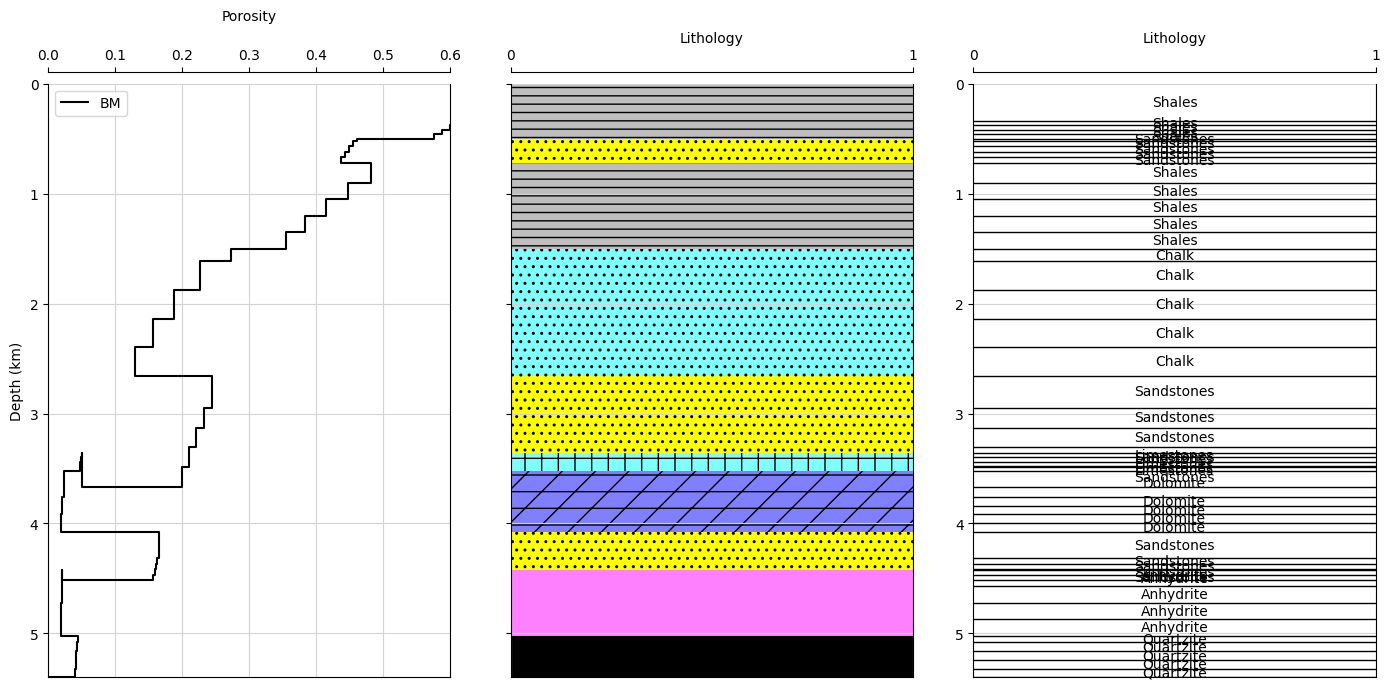

In [35]:
makeplot_porosity(porosity_df, 0, max(decompaction_corrected_df['0.0']))

In [36]:
def makeplot_porosity_2pic(property, top_depth, bottom_depth):
    # fig = plt.figure(constrained_layout=True, figsize=(10, 6))
    # ax = fig.subplots(1, 2,  sharex=False)

    fig, ax = plt.subplots(figsize=(8, 8))

    ax1 = plt.subplot2grid((1,2), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,2), (0,1), rowspan=1, colspan = 1, sharey = ax1)

    # As our curve scales will be detached from the top of the track,
    # this code adds the top border back in without dealing with splines
    # ax10 = ax1.twiny()
    # ax10.xaxis.set_visible(False)

    # ax13 = ax4.twiny()
    # ax13.xaxis.set_visible(False)

### Plot 1
    # Geotherms
    # ax1.plot(new_df_ref['porosity'], new_df['depth_dc'], label='Petromod', color='red', lw=3)
    ax1.plot(new_df['porosity'], new_df['depth_dc'], label='BM', color='black', lw=3)

    ax1.set_xlabel(f'Porosity [n/n]', labelpad=20)
    ax1.set_ylabel(f'Depth [km]')
    ax1.legend(loc='upper left')
    ax1.set_xlim(0, 0.6)

    # Lithology
    ax1.xaxis.label.set_color("black")
    ax1.tick_params(axis='x', colors="black")
    ax1.spines["top"].set_edgecolor("black")

    depth_start = 0

    for lit, depth in zip(work_layers.index, decompaction_corrected_df['0.0']):
        key = int(lit)
        color = work_layers.at[lit, 'Color']
        hatch = work_layers.at[lit, 'Index']

        depth_values = [depth_start, depth]
        depth_start = depth

        ax1.fill_betweenx(depth_values, 0, 1, facecolor=color, hatch=hatch, alpha=0.2)


### Plot 2
    ax2.set_xlabel("Lithology")
    ax2.set_xlim(0, 1)
    ax2.xaxis.label.set_color("black")
    ax2.tick_params(axis='x', colors="black")
    ax2.spines["top"].set_edgecolor("black")
    ax2.set_xticks([0, 1])

    depth_start = 0

    for lit, depth in zip(property["Lithology_type"], decompaction_corrected_df['0.0']):
        key = lit
        depth_values = [depth_start, depth]
        depth_start = depth

        label_position = (0.5, sum(depth_values) / 2)  # Assuming x position is at 0.5
        ax2.text(label_position[0], label_position[1], key, ha='center', va='center')
        ax2.plot([0, 1], [depth, depth], color='black', linewidth=1)  # Assuming black color and linewidth of 1


    for ax in [ax1, ax2]:
        ax.set_ylim(bottom_depth, top_depth)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))

    for ax in [ax2]:
        plt.setp(ax.get_yticklabels(), visible = False)

    plt.tight_layout()
    fig.subplots_adjust(wspace = 0.15)
    return plt.savefig("porosity-depth.png")

<ipython-input-36-d4e8eaa16688>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((1,2), (0,0), rowspan=1, colspan = 1)


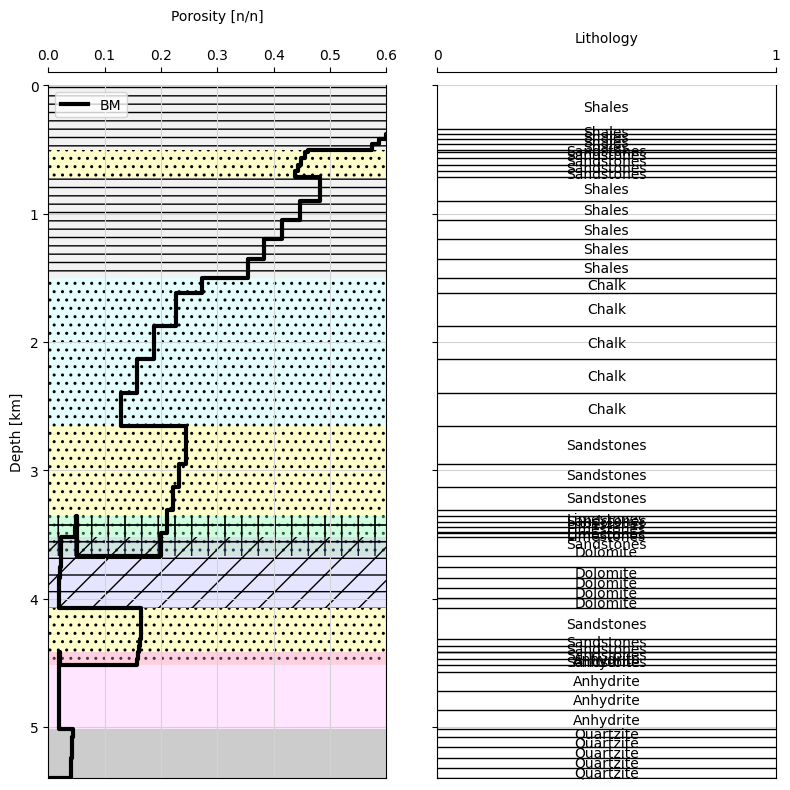

In [37]:
makeplot_porosity_2pic(porosity_df, 0, max(decompaction_corrected_df['0.0']))

In [ ]:
makeplot_porosity_2pic(porosity_df, 0, max(decompaction_corrected_df['0']))

KeyError: '0'

### Tectonic driving subsidence [A58.7]

In [70]:
### Tectonic driving subsidence [A58.7]
output_df = pd.DataFrame()
RoWater, RoMantle = 1000, 3300
# y = tectonic_subsidence(RoMantle, RoWater, density_column, thicknesses)

# decompaction_corrected_df.iloc[2:]
thicknesses = decompaction_corrected_df.iloc[:, 2:decompaction_corrected_df.shape[1]]
density_column_test = density_column_df.iloc[:, 2:density_column_df.shape[1]]


# Initialize an empty list to store the output values
output_values = []


col_name = list(density_column_test.columns)

for columns2, column_name in zip(thicknesses.columns, density_column_test.columns):
  if all(item == 0 for item in density_column_test[column_name].values):
    y = tectonic_subsidence(RoMantle, RoWater,
                            np.zeros(len(density_column_test[column_name].values)),
                            np.zeros(len(thicknesses[columns2].values)))

    output_values.append(y)

  else:
      y = tectonic_subsidence(RoMantle, RoWater,
                              density_column_test[column_name].values,
                              thicknesses[columns2].values)
      output_values.append(y)

output_df = pd.DataFrame(output_values).T[::-1].rename(columns=dict(enumerate(col_name)))

In [71]:
output_df

260     257.0     254.0     251.0     248.0     245.0     250.0     240.0  \
49  0.0  0.040899  0.080892  0.118878  0.157959  0.196092  0.220594  0.246424   
48  0.0  0.000000  0.040565  0.079477  0.118794  0.157289  0.187797  0.217176   
47  0.0  0.000000  0.000000  0.039855  0.079419  0.118288  0.154846  0.187800   
46  0.0  0.000000  0.000000  0.000000  0.039825  0.079080  0.121733  0.158292   
45  0.0  0.000000  0.000000  0.000000  0.000000  0.039654  0.088450  0.128643   
44  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.062093  0.105240   
43  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.007104  0.055841   
42  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.006392   
41  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
40  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
39  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
38  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
37  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
36  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
35  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
34  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
33  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
32  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
31  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
30  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
29  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
28  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
27  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
26  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
25  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
24  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
23  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
22  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
21  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
20  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
19  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
18  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
17  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
16  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
15  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
14  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
13  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
12  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
11  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
10  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1   0.0  0.000000  0.000000  0.0000

#### Plot: "Tectonic subsidence Y after decompaction and backstripping" (Comparison with Petromod) [Fig. A58.2]


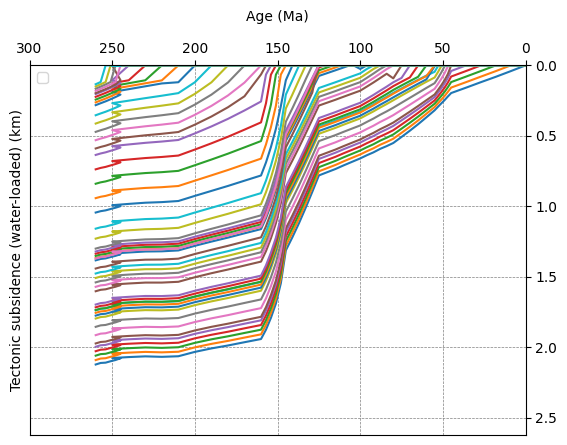

In [92]:
age_values  = output_df.columns.astype(float).tolist()[::-1]

# work_layers_copy = work_layers.copy()

# # Plot the lines for each row in work_layers_copy
for row_index, row in output_df.iterrows():
    plt.plot(age_values, row.values)

# # Calculate sea level and sea level today
# sea_level = df_well[1:df_well.shape[0]]['Paleobathymetry, Ma'] / 1000
# sea_level_today = df_well[1:df_well.shape[0]]['Sea level, m'] / 1000

# # Plot sea level and present-day sea level
# plt.plot(age_values, (abs(sea_level - sea_level_today))[::-1], 'k--', label='Sea level')
# plt.plot(age_values, np.zeros(work_layers_copy.shape[1]), 'k--', label='present-day sea level')

# # Fill the space between the two sea level plots with blue color
# plt.fill_between(age_values, np.zeros(work_layers_copy.shape[1]),
#  (abs(sea_level - sea_level_today))[::-1], color='blue', alpha=0.2, label='Sea level' )

# Additional plotting settings
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.axis([np.round(max(age_values), -2), np.min(age_values), np.max(output_df)+0.5, 0])

plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)

# Move the x-axis label to the top
plt.xlabel(f'Age (Ma)', labelpad=20)
plt.ylabel(f'Tectonic subsidence (water-loaded) (km)')
plt.gca().xaxis.set_label_coords(0.5, 1.15)

plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Display the plot
plt.show()

In [51]:
# Data reference Petromod
data_ref = pd.read_excel('/content/BM/Charts_Petromod.xlsx', sheet_name='Petromod Depth', skiprows=0, header=0, engine='openpyxl')
data_ref = data_ref.applymap(lambda x: x.split('\t') if isinstance(x, str) else x)

In [52]:
plt.figure(figsize=(8, 7))

    # Our data
work_layers = decompaction_corrected_df.drop(['Lithology_type', 'Event_name'], axis=1, inplace=False)
age_values = [int(age.split(' Ma')[0]) for age in work_layers.columns.tolist()]
work_layers_copy = work_layers.copy()

# Plot the lines for each row in work_layers_copy
for row_index, row in work_layers_copy.iterrows():
  plt.plot(age_values, row.values, linestyle='solid')

    # Petromode
work_layers = data_ref.drop(['Unnamed: 0', 'Lithology_type', 'Event_name'], axis=1, inplace=False)
work_layers_copy = work_layers.copy()

for row_index, row in work_layers_copy.iterrows():
  plt.plot(age_values, row.values, linestyle='dashed')

# Calculate sea level and sea level today
sea_level = df_well[1:df_well.shape[0]]['Paleobathymetry, Ma'] / 1000
sea_level_today = df_well[1:df_well.shape[0]]['Sea level, m'] / 1000

# # Plot sea level and present-day sea level
# plt.plot(age_values, (abs(sea_level - sea_level_today))[::-1], 'k--', label='Sea level')
# plt.plot(age_values, np.zeros(work_layers_copy.shape[1]), 'k--', label='present-day sea level')

# Fill the space between the two sea level plots with blue color
plt.fill_between(age_values, np.zeros(work_layers_copy.shape[1]),
 (abs(sea_level - sea_level_today))[::-1], color='blue', alpha=0.2, label='Sea level' )

# Additional plotting settings
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
# plt.axis([np.round(max(age_values), -2), np.min(age_values), np.max(work_layers_copy), -1])
plt.axis([262, 0, np.max(work_layers_copy), 0])

plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
# plt.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)

# Move the x-axis label to the top
plt.xlabel(f'Millions years before present', labelpad=10, fontsize=12)
plt.ylabel(f'Depth(km)', labelpad=10, fontsize=12)
plt.gca().xaxis.set_label_coords(0.5, 1.15)

plt.legend(loc='lower left')
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Display the plot
plt.show()
plt.savefig("age-depth.png")

ValueError: invalid literal for int() with base 10: '257.0'

<Figure size 800x700 with 0 Axes>

### Step 4: Thermal conductivity of the basin-fill

In [53]:
def bulk_thermal_conductivity(tc_matrix, tc_inclusion, porosity):
  return tc_matrix*(1-porosity) + tc_inclusion*porosity

In [54]:
def bulk_thermal_conductivity_geomean(tc_matrix, tc_inclusion, porosity):
  return tc_inclusion**porosity * tc_matrix**(1-porosity)

In [55]:
def geotherm_constant_heat(surface_T, basal_HF, depth, tc_bulk):
  return surface_T + (-basal_HF*depth * tc_bulk**-1)

In [94]:
tc_bulk_df = pd.DataFrame()

age_list = list(work_layers['Age (Ma)'][0:])
# age_list  = work_layers.columns.astype(float)
print(age_list)

for i, age in enumerate(age_list, start=0):

    work_layers_copy = work_layers.copy()
    print(age)

    tc_bulk_list = []

    # thinkness_list = []
    # thinkness_corrected_list = []
    # porosity_average_list = []
    # porosity_test = []
    # density_list = []
    # density_column = []
    # density_column_total = []

    RoWater, RoMantle = 1000, 3300
    tc_water = 0.60

    sea_level = work_layers_copy.loc[work_layers_copy['Lithology_type'] == str(lithology), 'Paleobathymetry, Ma'].iloc[0]/1000
    sea_level_today = work_layers_copy.loc[work_layers_copy['Lithology_type'] == str(lithology), 'Sea level, m'].iloc[0]/1000

    print('Age', age)

    ### расчет corrected_decompaction for Fundament (not in work_layer)
    if int(age) == age_list[-1]:
          tc_bulk = 0
          tc_bulk_list.append(tc_bulk)


### расчет для слоев с заданной литологией (work_layers)
    for row_index, row in enumerate(work_layers_copy[i::].itertuples(), start=i):

      lithology = work_layers_copy.at[row.Index, 'Lithology_type']
      layers_name = work_layers_copy.at[row.Index, 'Event_name']
      phi0 = porosity_df.loc[(porosity_df['Lithology_type'] == str(lithology)) & (porosity_df['Event_name'] == layers_name), f'{age}'].iloc[0]
      tc_matrix = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'TC matrix'].iloc[0]

      # c = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Exp_decay, km-1'].iloc[0]
      # RoGrain = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Grain density'].iloc[0]
      # y1 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth top, m'].iloc[0]
      # y2 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth bottom, m'].iloc[0]

### Bulk thermal conductivity
      tc_bulk = bulk_thermal_conductivity(tc_matrix, tc_water, phi0)
      # tc_bulk = bulk_thermal_conductivity_geomean(tc_matrix, tc_water, phi0)
      tc_bulk_list.append(tc_bulk)

      print(row_index, lithology, layers_name, phi0, tc_bulk)


### Save results in table
    new_col_name = f'{age}'
    ### Save result for decompaction in table
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(tc_bulk_list):] = tc_bulk_list
    new_col_values = resized_list_new
    tc_bulk_df[new_col_name] = new_col_values

[0.0, 9.0, 18.0, 27.0, 36.0, 45.0, 47.0, 49.0, 51.0, 53.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 84.0, 88.0, 92.0, 96.0, 100.0, 105.0, 110.0, 115.0, 120.0, 125.0, 129.0, 133.0, 137.0, 141.0, 145.0, 148.0, 151.0, 154.0, 157.0, 160.0, 170.0, 180.0, 190.0, 200.0, 210.0, 220.0, 230.0, 240.0, 250.0, 245.0, 248.0, 251.0, 254.0, 257.0]
0.0
Age 0.0
0 Shales Layer 10_1 0.624 1.1264
1 Shales Layer 10_2 0.611 1.1446
2 Shales Layer 10_3 0.599 1.1614
3 Shales Layer 10_4 0.587 1.1782
4 Shales Layer 10_5 0.575 1.195
5 Sandstones Layer 9_1 0.461 3.2411
6 Sandstones Layer 9_2 0.455 3.2704999999999997
7 Sandstones Layer 9_3 0.449 3.2998999999999996
8 Sandstones Layer 9_4 0.443 3.3292999999999995
9 Sandstones Layer 9_5 0.437 3.3587
10 Shales Layer 8_1 0.482 1.3252
11 Shales Layer 8_2 0.447 1.3741999999999999
12 Shales Layer 8_3 0.414 1.4204
13 Shales Layer 8_4 0.383 1.4638
14 Shales Layer 8_5 0.355 1.5030000000000001
15 Chalk Layer 7_1 0.273 2.5629
16 Chalk Layer 7_2 0.227 2.6871
17 Chalk Layer 7_3 0.188 2

In [95]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
tc_bulk_df['Event_name'] = work_layers['Event_name']
tc_bulk_df['Lithology_type'] = work_layers['Lithology_type']
tc_bulk_df= tc_bulk_df[tc_bulk_df.columns[::-1]]

tc_bulk_df.to_csv('/content/TC_bulk.csv', index=True)

In [96]:
tc_bulk_df

Lithology_type  Event_name   257.0   254.0   251.0   248.0   245.0   250.0  \
0          Shales  Layer 10_1  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1          Shales  Layer 10_2  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
2          Shales  Layer 10_3  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
3          Shales  Layer 10_4  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
4          Shales  Layer 10_5  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
5      Sandstones   Layer 9_1  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
6      Sandstones   Layer 9_2  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
7      Sandstones   Layer 9_3  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
8      Sandstones   Layer 9_4  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
9      Sandstones   Layer 9_5  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
10         Shales   Layer 8_1  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
11         Shales   Layer 8_2  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
12         Shales   Layer 8_3  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
13         Shales   Layer 8_4  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
14         Shales   Layer 8_5  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
15          Chalk   Layer 7_1  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
16          Chalk   Layer 7_2  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
17          Chalk   Layer 7_3  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
18          Chalk   Layer 7_4  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
19          Chalk   Layer 7_5  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
20     Sandstones   Layer 6_1  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
21     Sandstones   Layer 6_2  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
22     Sandstones   Layer 6_3  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
23     Sandstones   Layer 6_4  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
24     Sandstones   Layer 6_5  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
25     Limestones   Layer 5_1  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
26     Limestones   Layer 5_2  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
27     Limestones   Layer 5_3  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
28     Limestones   Layer 5_4  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
29     Limestones   Layer 5_5  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
30       Dolomite   Layer 4_1  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
31       Dolomite   Layer 4_2  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
32       Dolomite   Layer 4_3  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
33       Dolomite   Layer 4_4  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
34       Dolomite   Layer 4_5  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
35     Sandstones   Layer 3_1  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
36     Sandstones   Layer 3_2  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
37     Sandstones   Layer 3_3  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
38     Sandstones   Layer 3_4  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
39     Sandstones   Layer 3_5  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
40      Anhydrite   Layer 2_1  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
41      Anhydrite   Layer 2_2  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
42      Anhydrite   Layer 2_3  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
43      Anhydrite   Layer 2_4  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
44      Anhydrite   Layer 2_5  0.0000  0.0000  0.0000  0.0000  0.0000  6.0207   
45      Quartzite   Layer 1_1  0.0000  0.0000  0.0000  0.0000  6.3013  6.3652   
46      Quartzite   Layer 1_2  0.0000  0.0000  0.0000  6.3013  6.3368  6.4007   
47      Quartzite   Layer 1_3  0.0000  0.0000  6.3013  6.3368  6.3794  6.4362   
48      Quartzite   Layer 1_4  0.0

## Step 5. Calculation of the geotherm with variable thermal conductivity (a constant heat flow from the mantle)



## Step 6. The radiogenic heat contribution: Eqn. [A58.10]

In [97]:
def linear_geotherm(G, y):
  return G*y

In [98]:
def linear_geotherm_2(T0, qm, A, yc, depth, K):
  return T0 + ((-Qm + A*yc)/K)*depth - (A/(2*K)*depth**2)

### Ap.13: Effects of variable radiogenic heating and thermal conductivity on the geotherm in the basin-fill - CHECK

In [99]:
T_with_rad_heat = pd.DataFrame()
T_without_rad_heat = pd.DataFrame()
T_linear_geotherm =  pd.DataFrame()

age_list = list(work_layers['Age (Ma)'][1:2])
print(age_list)


for i, age in enumerate(age_list, start=0):

    work_layers_copy = work_layers.copy()

    T_list = []
    T_list_constant = []
    T_linear_geotherm_values = []


    Qm = 0
    T0 = 15
    G = 20

    print('Age', age)


    sum_variables_1, sum_variables_2 = [], []
    sum_variables_3, sum_variables_4 = [], []
    sum_variables_5 = []
    layers_sum = []
    layers_sum_1 = []



### расчет для слоев с заданной литологией (work_layers)
    for row_index, row in enumerate(work_layers_copy[i::].itertuples(), start=i):

      lithology = work_layers_copy.at[row.Index, 'Lithology_type']
      layers_name = work_layers_copy.at[row.Index, 'Event_name']

      A = work_layers.loc[work_layers['Lithology_type'] == str(lithology), 'Layer radiogenic\nheat production'].iloc[0] * 10**-6
      K = work_layers.loc[work_layers['Lithology_type'] == str(lithology), 'Layer bulk\nconductivity'].iloc[0]

      thickness_layer = work_layers.loc[work_layers['Lithology_type'] == str(lithology), 'Thickness, m'].iloc[0]

      crust_depth = 5

      depth = work_layers.loc[work_layers['Lithology_type'] == str(lithology), 'Depth bottom, m'].iloc[0]

### With radio heat
      Qm = 30*10**-3 # Qm = 30 - ни где не указано в книги, сама подобрала
      if K == 0:
        sum_variables_1.append(0)
        sum_variables_2.append(0)
      else:
        layers_sum.append(thickness_layer)
        crust_depth = sum(layers_sum)

        sum_variables_1.append(((Qm+A*crust_depth)/K)*thickness_layer)
        sum_variables_2.append((A/(2*K))*(thickness_layer)**2)


      T = T0 + (sum(sum_variables_1) - sum(sum_variables_2))
      T_list.append(T)

      print(row_index, lithology, crust_depth, thickness_layer, K, A, T_list)



### without radio heat

      Qm = 25*10**-3
      A = 2.5 * 10**-6
      K= 3

###!!!!!!!!!!!!!!!!!!!!!! crust depth = 5km and change for each layer
      layers_sum_1.append(thickness_layer)
      crust_depth = sum(layers_sum_1)
###!!!!!!!!!!!!!!!!!!!!!!
      if K == 0:
        sum_variables_3.append(0)
      else:
        sum_variables_3.append(((Qm+A*crust_depth)/K)*thickness_layer)
        sum_variables_4.append((A/(2*K))*(thickness_layer)**2)

      T_no_heat = T0 + (sum(sum_variables_3) - sum(sum_variables_4))
      T_list_constant.append(T_no_heat)


# ### Linear teady-stage geotherm Appendix 12
      Qm = -60 * 10**-3
      A = 0
      yc = 30 *1000
      K= 3
      depth *=1000

      # T_linear_geotherm_values.append(T0 + ((-Qm + A*yc)/K)*depth - (A/(2*K)*depth**2))

      T_linear_geotherm_values.append(linear_geotherm_2(T0, qm, A, yc, depth, K))

      print(T_list_constant)
      print(T_linear_geotherm_values)

### Save results in table

### with radio heat
    new_col_name = f'{age}'
    ### Save result for decompaction in table
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list):] = T_list
    new_col_values = resized_list_new
    T_with_rad_heat[new_col_name] = new_col_values

### without radio heat
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list_constant):] = T_list_constant
    new_col_values = resized_list_new
    T_without_rad_heat[new_col_name] = new_col_values


### Linear teady-stage geotherm Appendix 12
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list_constant):] = T_linear_geotherm_values
    new_col_values = resized_list_new
    T_linear_geotherm[new_col_name] = new_col_values

[9.0]
Age 9.0


KeyError: 'Layer radiogenic\nheat production'

In [ ]:
T0 = 15
Linear = T_linear_geotherm["0.0"].tolist()
Linear.insert(0, T0)


A_line = T_without_rad_heat["0.0"].tolist()
A_line.insert(0, T0)

C_line = T_with_rad_heat["0.0"].tolist()
C_line.insert(0, T0)

In [ ]:
y = work_layers["Depth bottom, m"].tolist()
y_add = y.insert(0, 0)

print(Linear, y)

plt.figure(figsize=(4, 8))
plt.plot(A_line, y , label='A (A added and constant)', marker='o', color='green')
# plt.plot(T_true['0'], y , label='McKenzie')
plt.plot(Linear, y , label='B Linear Geotherm', marker='o', color='red')
plt.plot(C_line, y , label='C (A & K variable)', marker='o', color='blue')


# plt.axis([np.round(max(age_values), -2), np.min(age_values), np.max(output_df)+0.5, 0])

plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
# plt.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)

# Move the x-axis label to the top
plt.xlabel(f'Tempreture', labelpad=20)
plt.ylabel(f'Depth (km)')
# plt.gca().xaxis.set_label_coords(0.5, 1.15)

plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.xlim(0, 140)
plt.ylim(0, 5)
plt.gca().invert_yaxis()
plt.show()

## Step 7. Calculation of the stretch factor

In [100]:
import warnings
from scipy import stats

warnings.filterwarnings("ignore")
warnings.filterwarnings("default")

In [101]:
from scipy.stats import linregress
from scipy.optimize import fsolve

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [102]:
output_df

260     257.0     254.0     251.0     248.0     245.0     250.0     240.0  \
49  0.0  0.040899  0.080892  0.118878  0.157959  0.196092  0.220594  0.246424   
48  0.0  0.000000  0.040565  0.079477  0.118794  0.157289  0.187797  0.217176   
47  0.0  0.000000  0.000000  0.039855  0.079419  0.118288  0.154846  0.187800   
46  0.0  0.000000  0.000000  0.000000  0.039825  0.079080  0.121733  0.158292   
45  0.0  0.000000  0.000000  0.000000  0.000000  0.039654  0.088450  0.128643   
44  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.062093  0.105240   
43  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.007104  0.055841   
42  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.006392   
41  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
40  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
39  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
38  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
37  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
36  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
35  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
34  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
33  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
32  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
31  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
30  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
29  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
28  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
27  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
26  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
25  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
24  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
23  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
22  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
21  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
20  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
19  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
18  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
17  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
16  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
15  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
14  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
13  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
12  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
11  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
10  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1   0.0  0.000000  0.000000  0.0000

In [103]:
# Define beta=stretch factor
def stretch_factor(beta):
  return E0 * (beta/np.pi) * np.sin(np.pi/beta) - slope


stretch_factor_df = pd.DataFrame()

tau = 50

for age in output_df.columns:

    col_list = list(output_df[age])
    thermal_subsidenence = col_list[::-1]

    if all(item == 0 for item in thermal_subsidenence):
        pass
    else:
        non_zero_values = [value for value in thermal_subsidenence if value != 0]
        time = np.array(work_layers['Age (Ma)'][0:len(non_zero_values)])

        x = 1-np.exp(-time/tau)
        y = list(map(lambda x: x * 1000, non_zero_values))

        # Perform linear regression
        slope, intercept, r_value, p_vzalue, std_err = linregress(x, y)

        # Calculate E0

        # Constant value - pp.497 (pdf), Table A19.1
        Tm = 1330
        yl = 125
        alpha_v =3.28*10**-5 #CLTE
        RoWater, RoMantle = 1030, 3300

        # # Example from book
        # slope, E0 = 1368, 3212

        E0 = (4*yl*RoMantle*alpha_v*Tm)/(np.pi**2*(RoMantle - RoWater))*1000 # [m]

        beta = fsolve(stretch_factor, 1.0)[0]

        # print(age, f"The value of beta is: {beta:.2f}")

        # Save results in table
        new_col_name = f'{age}'
        stretch_factor_df[new_col_name] = [beta]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The 

In [104]:
stretch_factor_df.to_csv('/content/Stretch_factor.csv', index=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [105]:
stretch_factor_df

257.0     254.0     251.0     248.0     245.0     250.0     240.0  \
0    1.0  1.076839  1.081917  1.088634  1.095329  1.100732  1.109409   

      230.0     220.0     210.0  ...      53.0      51.0      49.0      47.0  \
0  1.119512  1.130457  1.142004  ...  2.336262  2.404776  2.471444  2.528095   

       45.0      36.0      27.0      18.0      9.0       0.0  
0  2.561853  2.601433  2.635263  2.665893  2.67107  2.656196  

[1 rows x 50 columns]

In [110]:
for age in output_df.columns:

  col_list = list(output_df[age])
  thermal_subsidence = col_list[::-1]


  if all(item == 0 for item in thermal_subsidence):
      pass
  else:

    tau = 50
    non_zero_values = [value for value in thermal_subsidence if value != 0]

    time_array = output_df.columns.astype(float).tolist()
    time = np.array(time_array[0:len(non_zero_values)+1])

In [111]:
beta = stretch_factor_df["0.0"].iloc[0] # Значение, используемое для следующих расчетов
beta

2.656196022841953

## Step 8. Calculation of paleotemperatures using the reference uniform stretching model



#### Heat Flow: subsiding only

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

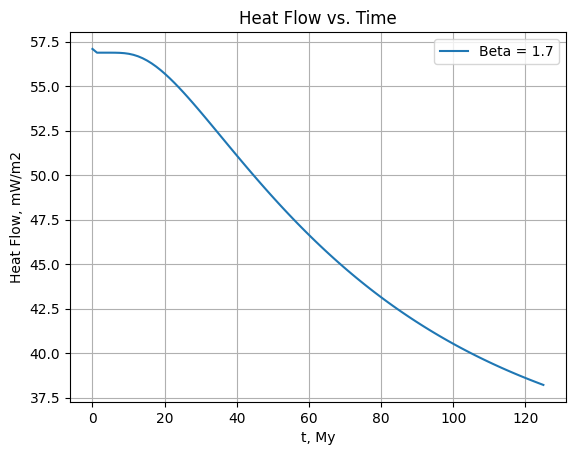

In [113]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

def heat_flux(beta, t):

    # Define the variables and parameters
    a = 125
    tau = 62.8
    lam = 3.5
    T1 = 1333
    N = 100  # Number of terms in the sum

    # Define the equation for T/Tm with z as a variable
    T_sum = 0
    for n in range(1, N+1):
        Cn = beta / (n * np.pi) * np.sin(n * np.pi / beta) * np.exp(-n**2 * t / tau)
        T_sum += Cn
    T_over_Tm = 0.8 * (1 + 2 * T_sum) # 0.8 = 34.5 mW/m2

    return T_over_Tm * 10**-3 * 60 * 697


# beta_list = [1, 1.25, 1.5, 2, 4]
beta_list = [1.7]
t = np.linspace(0, 125, 100)

plt.figure()
for beta in beta_list:
    plt.plot(t, heat_flux(beta, t), label=f'Beta = {beta}')

plt.xlabel('t, My')
plt.ylabel('Heat Flow, mW/m2')
plt.title('Heat Flow vs. Time')
plt.grid(True)
plt.legend()
# plt.ylim(0, 140)
plt.show()

#### Temperature calculation (variable Heat Flow (F) for diffrent age)

In [114]:
# import numpy as np
# import sympy as sp
# import matplotlib.pyplot as plt


def heat_flow_fundament_calculation(beta, t, Q_const, constant=False):

  ###
  # concstant = True: постоянный тепловой поток Q_const
  # Q_const: значение постоянного теплового потока, mW/m2

  ###

  if constant == True:
    return Q_const

  else:

    def tau_heat_flux(a, k):
      tau = a**2/(k * np.pi**2) # [second]
      # convert second to yaers, than to Million years
      seconds = tau
      years = seconds / 60 / 60 / 24 / 365.25  # Considering leap years
      return years * 10**-6 # [Myr]


    def heat_flux(beta, t):

        # Define the variables and parameters of lithosphere
        a = 125 * 1000 #m an initial lithosphere thickness
        k = 10**-6 #m2 s-1 thermal diffusivity of lithospheric rocks

        tau = tau_heat_flux(a, k)  # Myr Lithospheric time constant
        # tau = 62.8
        lam = 3.5 # Lithospheric thermal conductivity [W/mK]

        T1 = 1333
        N = 100 # Number of terms in the sum

        # Define the equation for F with z as a variable
        F_sum = 0
        for n in range(1, N+1):
            Cn = beta / (n * np.pi) * np.sin(n * np.pi / beta) * np.exp(-n**2 * t / tau)
            F_sum += Cn
        F_over_Tm = (lam*T1/a) * (1 + 2 * F_sum) # [mW/m2]
        return F_over_Tm

    return heat_flux(beta, t)

[0.0, 9.0, 18.0, 27.0, 36.0, 45.0, 47.0, 49.0, 51.0, 53.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 84.0, 88.0, 92.0, 96.0, 100.0, 105.0, 110.0, 115.0, 120.0, 125.0, 129.0, 133.0, 137.0, 141.0, 145.0, 148.0, 151.0, 154.0, 157.0, 160.0, 170.0, 180.0, 190.0, 200.0, 210.0, 220.0, 230.0, 240.0, 250.0, 245.0, 248.0, 251.0, 254.0, 257.0]
0.0 63.685954533544326
9.0 63.321699080040204
18.0 61.601506755504495
27.0 58.70081180532921
36.0 55.66392080784085
45.0 52.870550930991655
47.0 52.295536042771964
49.0 51.7380772163573
51.0 51.1982472399421
53.0 50.67599395824269
55.0 50.17116620969431
60.0 48.98368200632315
65.0 47.898518320242786
70.0 46.90940043828399
75.0 46.00949904623891
80.0 45.191873652900995
84.0 44.59244212214685
88.0 44.037980638132716
92.0 43.5253077437791
96.0 43.051413302898325
100.0 42.61346524273573
105.0 42.112554500661346
110.0 41.65887923841767
115.0 41.248051270259786
120.0 40.87606821155253
125.0 40.53928690306466


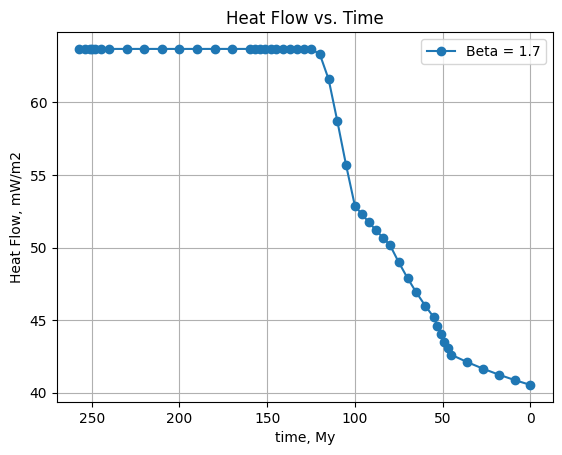

Age 0.0
0 Shales 40.0 40.0 0.04053928690306466
1 Shales 80.0 40.0 0.04053928690306466
2 Shales 120.0 40.0 0.04053928690306466
3 Shales 160.0 40.0 0.04053928690306466
4 Shales 200.0 40.0 0.04053928690306466
5 Sandstones 250.0 50.0 0.04053928690306466
6 Sandstones 300.0 50.0 0.04053928690306466
7 Sandstones 350.0 50.0 0.04053928690306466
8 Sandstones 400.0 50.0 0.04053928690306466
9 Sandstones 450.0 50.0 0.04053928690306466
10 Shales 600.0 150.0 0.04053928690306466
11 Shales 750.0 150.0 0.04053928690306466
12 Shales 900.0 150.0 0.04053928690306466
13 Shales 1050.0 150.0 0.04053928690306466
14 Shales 1200.0 150.0 0.04053928690306466
15 Chalk 1460.0 260.0 0.04053928690306466
16 Chalk 1720.0 260.0 0.04053928690306466
17 Chalk 1980.0 260.0 0.04053928690306466
18 Chalk 2240.0 260.0 0.04053928690306466
19 Chalk 2500.0 260.0 0.04053928690306466
20 Sandstones 2680.0 180.0 0.04053928690306466
21 Sandstones 2860.0 180.0 0.04053928690306466
22 Sandstones 3040.0 180.0 0.04053928690306466
23 Sandston

In [115]:
T_with_rad_heat = pd.DataFrame()
T_without_rad_heat = pd.DataFrame()
T_linear_geotherm =  pd.DataFrame()
age_list = list(work_layers['Age (Ma)'][0:])

# Heat flow
heat_flow = []

# print(age_list)

beta = 1.7
Qm_array = []
print(age_list)
for t in age_list:
  if t <= 125:
    Qm_array.append(heat_flow_fundament_calculation(beta, t, Q_const=63*10**-3,
                                                    constant=False))
    print(t, heat_flow_fundament_calculation(beta, t, Q_const=63*10**-3, constant=False)*10**3)
  else:
    Qm_array.insert(0, heat_flow_fundament_calculation(beta, 0, Q_const=63*10**-3,
                                                       constant=False))
# print(Qm_array)
Qm_array = Qm_array[::-1]
plt.plot(age_list, [x * 10**3 for x in Qm_array], label=f'Beta = {beta}', marker='o')

plt.xlabel('time, My')
plt.ylabel('Heat Flow, mW/m2')
plt.title('Heat Flow vs. Time')
plt.grid(True)
plt.legend()
plt.gca().invert_xaxis()
# plt.ylim(0, 140)
plt.show()
#  beta = stretch_factor_df[str(age)].iloc[0]

# Calculation for each age
for i, age in enumerate(age_list, start=0):

    work_layers_copy = work_layers.copy()

    T_list = []
    T_list_constant = []
    T_linear_geotherm_values = []

    T0 = 0
    G = 20

    print('Age', age)

    sum_variables_1, sum_variables_2 = [], []
    sum_variables_3, sum_variables_4 = [], []
    sum_variables_5 = []
    layers_sum = []
    heat_flow_list = []


### расчет для слоев с заданной литологией (work_layers)
    for row_index, row in enumerate(work_layers_copy[i::].itertuples(), start=i):

      lithology = work_layers_copy.at[row.Index, 'Lithology_type']
      layers_name = work_layers_copy.at[row.Index, 'Event_name']

      A = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Radiogenic Heat Production'].iloc[0]
      K = tc_bulk_df.loc[row_index:].loc[tc_bulk_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]
      thickness_layer = decompaction_df.loc[row_index:].loc[decompaction_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]*1000

      # K = tc.loc[row_index:].loc[tc['Lithology_type'] == str(lithology), f'{age}'].iloc[0] ### reference Table  A58.8

# ### Depth values
      depth = decompaction_corrected_df.loc[row_index:].loc[decompaction_corrected_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]*1000
# ### Initial depth values
      y1 = work_layers.loc[work_layers['Event_name'] == str(layers_name), 'Depth top, m'].iloc[0]
      y2 = work_layers.loc[work_layers['Event_name'] == str(layers_name), 'Depth bottom, m'].iloc[0]

      layers_sum.append(thickness_layer)
      crust_depth = sum(layers_sum)
      Qm = Qm_array[i]


### With radio heat
      if K == 0:
        sum_variables_1.append(0)
        sum_variables_2.append(0)
      else:
        sum_variables_1.append(((Qm+A*crust_depth)/K)*thickness_layer)
        sum_variables_2.append((A/(2*K))*(thickness_layer)**2)


      T = T0 + (sum(sum_variables_1) - sum(sum_variables_2))
      T_list.append(T)
      heat_flow_list.append(Qm)

      print(row_index, lithology, crust_depth, thickness_layer, Qm )

### without radio heat
      # Qm = 63*10**-3
      A = 0

      if K == 0:
        sum_variables_3.append(0)
      else:
        sum_variables_3.append(((Qm+A*crust_depth)/K)*thickness_layer)
        sum_variables_4.append((A/(2*K))*(thickness_layer)**2)

      T_no_heat = T0 + (sum(sum_variables_3) - sum(sum_variables_4))
      T_list_constant.append(T_no_heat)

      # print(row_index, lithology, crust_depth, thickness_layer, Qm )

# ### Linear teady-stage geotherm Appendix 12
      T_linear_geotherm_values.append(linear_geotherm(G, depth/1000))

### Save results in table

### with radio heat
    new_col_name = f'{age}'
    ### Save result for decompaction in table
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list):] = T_list
    new_col_values = resized_list_new
    T_with_rad_heat[new_col_name] = new_col_values

### without radio heat
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list_constant):] = T_list_constant
    new_col_values = resized_list_new
    T_without_rad_heat[new_col_name] = new_col_values


### Linear teady-stage geotherm Appendix 12
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list_constant):] = T_linear_geotherm_values
    new_col_values = resized_list_new
    T_linear_geotherm[new_col_name] = new_col_values


In [ ]:
save_to_csv(T_with_rad_heat, work_layers, "Geotherm_with_A")
save_to_csv(T_without_rad_heat, work_layers, "Geotherm_without_A")
save_to_csv(T_linear_geotherm, work_layers, "Linear_Geotherm")

In [ ]:
# ### добавление колонок Lithology_type,	Event_name
# work_layers.reset_index(drop=True, inplace=True)
# T_with_rad_heat['Event_name'] = work_layers['Event_name']
# T_with_rad_heat['Lithology_type'] = work_layers['Lithology_type']
# T_with_rad_heat = T_with_rad_heat[T_with_rad_heat.columns[::-1]]

# T_with_rad_heat.to_csv('/content/T_with_rad_heat.csv', index=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# ### добавление колонок Lithology_type,	Event_name
# work_layers.reset_index(drop=True, inplace=True)
# T_without_rad_heat['Event_name'] = work_layers['Event_name']
# T_without_rad_heat['Lithology_type'] = work_layers['Lithology_type']
# T_without_rad_heat = T_without_rad_heat[T_without_rad_heat.columns[::-1]]

# T_without_rad_heat.to_csv('/content/T_without_rad_heat.csv', index=True)

In [ ]:
T_with_rad_heat

0.0       45.0       47.0       49.0       51.0       53.0  \
0    7.010382   0.000000   0.000000   0.000000   0.000000   0.000000   
1    7.639941   0.692725   0.000000   0.000000   0.000000   0.000000   
2    8.264758   1.378933   0.725889   0.000000   0.000000   0.000000   
3    8.884918   2.058764   1.444939   0.742150   0.000000   0.000000   
4    9.500502   2.732355   2.157298   1.477335   0.746016   0.000000   
5   10.111591   3.400844   2.863109   2.193309   1.485026   0.763938   
6   32.301447  28.335897  29.189704  29.405588  29.672057  30.027108   
7   34.410077  30.642566  31.616297  31.901282  32.220710  32.648922   
8   36.466523  32.880742  33.950448  34.281506  34.665915  35.143208   
9   38.477503  35.045144  36.204912  36.577695  37.004960  37.528893   
10  40.449001  37.145961  38.390664  38.801406  39.269934  39.833932   
11  42.386405  39.205579  40.531135  40.962674  41.468919  42.069411   
12  44.294609  41.227648  42.616677  43.084102  43.625035  44.245006   
13  46.176328  43.204322  44.668683  45.153665  45.728409  46.383062   
14  48.034080  45.153601  46.676889  47.192340  47.784797  48.471353   
15  49.871903  47.078087  48.659409  49.204866  49.812784  50.530720   
16  51.691924  48.981955  50.620559  51.180661  51.816914  52.550595   
17  56.225483  53.674330  55.448404  56.049538  56.728017  57.505425   
18  60.679415  58.267442  60.172686  60.813559  61.527614  62.347299   
19  63.349446  61.012306  62.993315  63.649484  64.376973  65.213180   
20  66.583967  64.324894  66.395068  67.067029  67.814086  68.667523   
21  68.997909  66.800865  68.944634  69.629203  70.392061  71.269574   
22  70.244297  68.074606  70.253746  70.945983  71.715563  72.600082   
23  71.490108  69.348918  71.563430  72.262120  73.038417  73.929934   
24  72.735343  70.622628  72.872478  73.577616  74.360624  75.259133   
25  73.981149  71.895736  74.180893  74.892472  75.682183  76.587679   
26  74.371644  72.294794  74.590433  75.303849  76.095476  77.003383   
27  74.762068  72.693772  74.999883  75.715135  76.509073  77.418990   
28  75.152420  73.092671  75.409244  76.126329  76.922576  77.834503   
29  75.543076  73.491490  75.818515  76.537432  77.335986  78.249919   
30  75.933660  73.890229  76.227697  76.948838  77.749302  78.665240   
31  76.324173  74.288890  76.636790  77.360153  78.162525  79.080466   

         55.0       80.0       82.0       84.0  ...      222.5     235.0  \
0    0.000000   0.000000   0.000000   0.000000  ...   0.000000  0.000000   
1    0.000000   0.000000   0.000000   0.000000  ...   0.000000  0.000000   
2    0.000000   0.000000   0.000000   0.000000  ...   0.000000  0.000000   
3    0.000000   0.000000   0.000000   0.000000  ...   0.000000  0.000000   
4    0.000000   0.000000   0.000000   0.000000  ...   0.000000  0.000000   
5    0.000000   0.000000   0.000000   0.000000  ...   0.000000  0.000000   
6   30.476465   0.000000   0.000000   0.000000  ...   0.000000  0.000000   
7   33.173735   7.193180   0.000000   0.000000  ...   0.000000  0.000000   
8   35.718583  12.215276   7.435181   0.000000  ...   0.000000  0.000000   
9   38.167193  16.266594  12.577698   7.651933  ...   0.000000  0.000000   
10  40.515847  19.780833  16.718799  12.892139  ...   0.000000  0.000000   
11  42.791092  22.935006  20.273104  17.096784  ...   0.000000  0.000000   
12  45.003080  25.824633  23.466322  20.712110  ...   0.000000  0.000000   
13  47.158651  28.541882  26.394058  23.945080  ...   0.000000  0.000000   
14  49.279651  31.109298  29.130953  26.914867  ...   0.000000  0.000000   
15  51.355687  33.559763  31.717811  29.692649  ...   0.000000  0.000000   
16  53.405235  35.924909  34.190012  32.319412  ...   0.000000  0.000000   
17  58.399489  41.371625  39.779192  38.073958  ...   0.000000  0.000000   
18  63.279594  46.587783  45.107513  43.541413  ...   0.000000  0.000000   
19  66.162653  49.575390  48.151402  46.630847  ...   0.000000  0.000000   
20  69.634977  53.104284  51.712746  

In [ ]:
T_with_rad_heat_test

0.0       45.0       47.0       49.0       51.0       53.0  \
0    8.133534   0.000000   0.000000   0.000000   0.000000   0.000000   
1    9.118672   1.095712   0.000000   0.000000   0.000000   0.000000   
2   10.093619   2.176678   1.141782   0.000000   0.000000   0.000000   
3   11.058491   3.244085   2.268317   1.193255   0.000000   0.000000   
4   12.013401   4.298119   3.380799   2.370705   1.199256   0.000000   
5   12.958461   5.341316   4.479418   3.514591   2.382634   1.227821   
6   38.223425  34.012111  34.634083  35.428808  35.483877  35.633670   
7   40.845219  36.926880  37.699861  38.671072  38.809190  39.069229   
8   43.371360  39.716923  40.608603  41.720731  41.954901  42.291434   
9   45.813587  42.381311  43.382196  44.624427  44.923990  45.333242   
10  48.182645  44.938371  46.040093  47.402918  47.765384  48.234929   
11  50.488429  47.419145  48.614709  50.074759  50.493511  51.016668   
12  52.740114  49.829986  51.098335  52.671812  53.141060  53.696552   
13  54.942643  52.166865  53.520184  55.181534  55.699874  56.306027   
14  57.100668  54.452958  55.871810  57.633136  58.180909  58.832325   
15  59.222067  56.693087  58.176303  60.035876  60.608569  61.304417   
16  61.310895  58.895421  60.442050  62.380701  62.991819  63.713299   
17  67.707288  65.557003  67.286517  69.469538  70.162685  70.970119   
18  73.901093  71.980965  73.887834  76.307866  77.066511  77.957543   
19  76.859930  75.033734  77.018828  79.538523  80.315301  81.231049   
20  80.582981  78.851027  80.934945  83.582277  84.392969  85.336576   
21  83.865172  82.232591  84.416800  87.174784  88.019809  89.006777   
22  85.346477  83.746878  85.972637  88.787719  89.643897  90.642922   
23  86.830437  85.267310  87.534886  90.403932  91.271311  92.282446   
24  88.317051  86.790590  89.100167  92.023424  92.902052  93.925348   
25  89.809551  88.316718  90.668481  93.646195  94.536120  95.571630   
26  90.305507  88.825081  91.190480  94.185823  95.079347  96.120060   
27  90.801303  89.333285  91.712322  94.725301  95.623696  96.668343   
28  91.296936  89.841329  92.234008  95.264628  96.167895  97.216480   
29  91.793573  90.349213  92.755538  95.803805  96.711946  97.764469   
30  92.290048  90.856938  93.276912  96.344090  97.255848  98.312310   
31  92.786362  91.364502  93.798129  96.884226  97.799601  98.860005   

          55.0       80.0       82.0       84.0  ...      222.5     235.0  \
0     0.000000   0.000000   0.000000   0.000000  ...   0.000000  0.000000   
1     0.000000   0.000000   0.000000   0.000000  ...   0.000000  0.000000   
2     0.000000   0.000000   0.000000   0.000000  ...   0.000000  0.000000   
3     0.000000   0.000000   0.000000   0.000000  ...   0.000000  0.000000   
4     0.000000   0.000000   0.000000   0.000000  ...   0.000000  0.000000   
5     0.000000   0.000000   0.000000   0.000000  ...   0.000000  0.000000   
6    35.875104   0.000000   0.000000   0.000000  ...   0.000000  0.000000   
7    39.424858  10.001148   0.000000   0.000000  ...   0.000000  0.000000   
8    42.726197  16.940880  10.334953   0.000000  ...   0.000000  0.000000   
9    45.860467  22.448406  17.434540  10.633326  ...   0.000000  0.000000   
10   48.829461  27.141147  23.057209  17.860629  ...   0.000000  0.000000   
11   51.671372  31.278342  27.794643  23.559773  ...   0.000000  0.000000   
12   54.405046  35.004949  31.974419  28.368872  ...   0.000000  0.000000   
13   57.043141  38.455999  35.741867  32.591446  ...   0.000000  0.000000   
14   59.616290  41.671044  39.209899  36.406331  ...   0.000000  0.000000   
15   62.115715  44.699529  42.441567  39.919844  ...   0.000000  0.000000   
16   64.565611  47.589917  45.491407  43.195367  ...   0.000000  0.000000   
17   71.897112  55.618872  53.767145  51.758404  ...   0.000000  0.000000   
18   78.957269  63.165185  61.500142  59.731237  ...   0.000000  0.000000   
19   82.256767  66.555004  64.958043  63.247251  ...   0.000000  0.000000   
20   86.392069  

###Sekiguchi–Waples Model

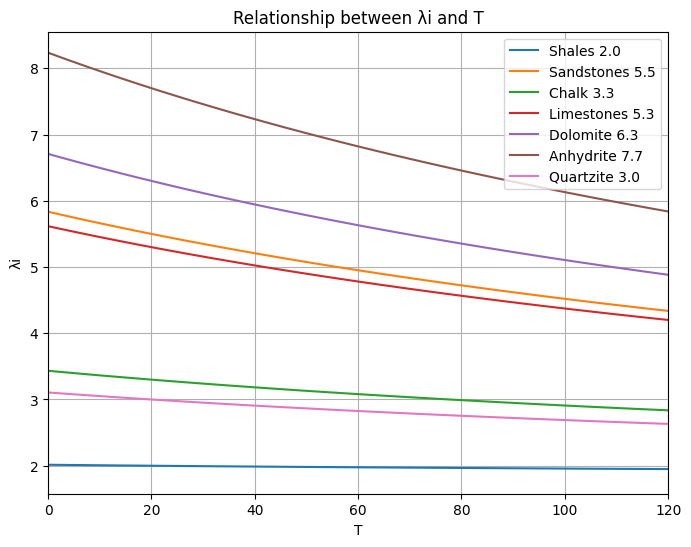

In [116]:
def Sekiguchi_Waples(T, lambda_m, correction=True):
  ###
  # return thermal conductivity depending from tempreture
  ###
  if correction == True:
    return 358 * (1.0227 * lambda_m - 1.882) * (T**(-1) - 0.00068) + 1.84
  else:
    pass

# Get the unique values from the "TC matrix" column
lam_20_range = df_constast["TC matrix"].unique()
label_range = df_constast["Lithology_type"]

fig, ax = plt.subplots(figsize=(8, 6))

for lam_20, lit in zip(lam_20_range,label_range):

  T_range = np.linspace(0, 350, 100)

  lambda_m = lam_20
  lambda_i_values = [Sekiguchi_Waples(T+273.15, lambda_m, correction=True) for T in T_range]

  ax.plot(T_range, lambda_i_values, label=f'{lit} {lam_20}')

ax.set_xlabel('T')
ax.set_ylabel('λi')
ax.set_title('Relationship between λi and T')
ax.grid(True)
ax.legend()
plt.xlim(0, 120)
plt.show()

0.0 63.685954533544326
9.0 63.321699080040204
18.0 61.601506755504495
27.0 58.70081180532921
36.0 55.66392080784085
45.0 52.870550930991655
47.0 52.295536042771964
49.0 51.7380772163573
51.0 51.1982472399421
53.0 50.67599395824269
55.0 50.17116620969431
60.0 48.98368200632315
65.0 47.898518320242786
70.0 46.90940043828399
75.0 46.00949904623891
80.0 45.191873652900995
84.0 44.59244212214685
88.0 44.037980638132716
92.0 43.5253077437791
96.0 43.051413302898325
100.0 42.61346524273573
105.0 42.112554500661346
110.0 41.65887923841767
115.0 41.248051270259786
120.0 40.87606821155253
125.0 40.53928690306466
129.0 40.29297147470036
133.0 40.06550642126116
137.0 39.85545439630431
141.0 39.66148621253686
145.0 39.482373097884626


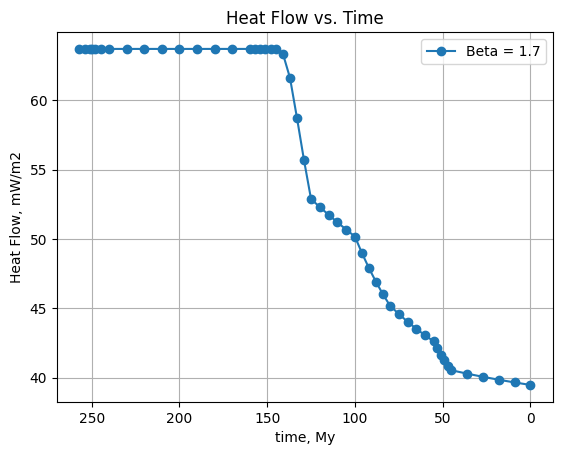

Age 0.0
0 Shales 0.624 1.6717579891628145 0.9460705465232708 1.1264 2.0
1 Shales 0.611 3.3196610551193095 0.9608422707778287 1.1446 2.0
2 Shales 0.599 4.947001272111785 0.9746547816821514 1.1614 2.0
3 Shales 0.587 6.554044983383051 0.9886569436611898 1.1782 2.0
4 Shales 0.575 8.141054453994425 1.002851560364203 1.195 2.0
5 Sandstones 0.461 9.126203723760144 2.0175812091571794 3.2411 5.5
6 Sandstones 0.455 10.10116298002084 2.0417454802459494 3.2704999999999997 5.5
7 Sandstones 0.449 11.066047009096993 2.066174374140134 3.2998999999999996 5.5
8 Sandstones 0.443 12.020968917864277 2.0908711346582045 3.3292999999999995 5.5
9 Sandstones 0.437 12.966040170775685 2.1158390425422033 3.3587 5.5
10 Shales 0.482 18.369535634154456 1.1207987506842048 1.3252 2.0
11 Shales 0.447 23.587814499586585 1.1679101715040303 1.3741999999999999 2.0
12 Shales 0.414 28.639454106743838 1.2140080135553875 1.4204 2.0
13 Shales 0.383 33.541577984529226 1.2588382339025117 1.4638 2.0
14 Shales 0.355 38.3157608105566

In [117]:
T_with_rad_heat_test = pd.DataFrame()
T_without_rad_heat_test = pd.DataFrame()
T_linear_geotherm_test =  pd.DataFrame()
# age_list = list(df_well['Age (Ma)'][1:])

# Heat flow
heat_flow = []

# print(age_list)

beta = 1.7
Qm_array = []
for t in age_list:
  if t <= 145:
    Qm_array.append(heat_flow_fundament_calculation(beta, t, Q_const=63*10**-3,
                                                    constant=False))
    print(t, heat_flow_fundament_calculation(beta, t, Q_const=63*10**-3, constant=False)*10**3)
  else:
    Qm_array.insert(0, heat_flow_fundament_calculation(beta, 0, Q_const=63*10**-3,
                                                       constant=False))
# print(Qm_array)
Qm_array = Qm_array[::-1]
plt.plot(age_list, [x * 10**3 for x in Qm_array], label=f'Beta = {beta}', marker='o')

plt.xlabel('time, My')
plt.ylabel('Heat Flow, mW/m2')
plt.title('Heat Flow vs. Time')
plt.grid(True)
plt.legend()
plt.gca().invert_xaxis()
# plt.ylim(0, 140)
plt.show()
#  beta = stretch_factor_df[str(age)].iloc[0]

# Calculation for each age
for i, age in enumerate(age_list, start=0):

    work_layers_copy = work_layers.copy()

    T_list = []
    T_list_constant = []
    T_linear_geotherm_values = []

    T0 = 0
    G = 20

    print('Age', age)

    sum_variables_1, sum_variables_2 = [], []
    sum_variables_3, sum_variables_4 = [], []
    sum_variables_5 = []
    layers_sum = []
    heat_flow_list = []


### расчет для слоев с заданной литологией (work_layers)
    for row_index, row in enumerate(work_layers_copy[i::].itertuples(), start=i):

      lithology = work_layers_copy.at[row.Index, 'Lithology_type']
      layers_name = work_layers_copy.at[row.Index, 'Event_name']

      A = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Radiogenic Heat Production'].iloc[0]
      K_20= tc_bulk_df.loc[row_index:].loc[tc_bulk_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]
      thickness_layer = decompaction_df.loc[row_index:].loc[decompaction_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]*1000

### Sekiguchi_Waples
      tc_matrix = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'TC matrix'].iloc[0]
      phi0 = porosity_df.loc[(porosity_df['Lithology_type'] == str(lithology)) & (porosity_df['Event_name'] == layers_name), f'{age}'].iloc[0]
      tc_water = 0.60

      if row_index == i:
        T_sg = T0
        if T0 == 0:
          T0 = 10**-3

        K_mtrx_corrected_SG = Sekiguchi_Waples(T_sg+273.15, tc_matrix, correction=True)
        # K = bulk_thermal_conductivity(K_mtrx_corrected_SG, tc_water, phi0)
        K = bulk_thermal_conductivity_geomean(K_mtrx_corrected_SG, tc_water, phi0)
      else:
        T_sg = T_list[-1]
        K_mtrx_corrected_SG = Sekiguchi_Waples(T_sg+273.15, tc_matrix, correction=True)
        # print(T_sg, lithology, tc_matrix, K_mtrx_corrected_SG)
        # K = bulk_thermal_conductivity(K_mtrx_corrected_SG, tc_water, phi0) # Arithmetic mean
        K = bulk_thermal_conductivity_geomean(K_mtrx_corrected_SG, tc_water, phi0) # Geometric mean


# ### Depth values
      depth = decompaction_corrected_df.loc[row_index:].loc[decompaction_corrected_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]*1000
# ### Initial depth values
      y1 = work_layers.loc[work_layers['Event_name'] == str(layers_name), 'Depth top, m'].iloc[0]
      y2 = work_layers.loc[work_layers['Event_name'] == str(layers_name), 'Depth bottom, m'].iloc[0]

      layers_sum.append(thickness_layer)
      crust_depth = sum(layers_sum)
      Qm = Qm_array[i]


### With radio heat
      if K == 0:
        sum_variables_1.append(0)
        sum_variables_2.append(0)
      else:
        sum_variables_1.append(((Qm+A*crust_depth)/K)*thickness_layer)
        sum_variables_2.append((A/(2*K))*(thickness_layer)**2)


      T = T0 + (sum(sum_variables_1) - sum(sum_variables_2))
      T_list.append(T)
      # heat_flow_list.append(Qm)

      # print(row_index, lithology, crust_depth, thickness_layer, K, Qm, T, phi0)
      print(row_index, lithology, phi0, T, K, K_20, tc_matrix)

### without radio heat
      # Qm = 63*10**-3
      A = 0

      if K == 0:
        sum_variables_3.append(0)
      else:
        sum_variables_3.append(((Qm+A*crust_depth)/K)*thickness_layer)
        sum_variables_4.append((A/(2*K))*(thickness_layer)**2)

      T_no_heat = T0 + (sum(sum_variables_3) - sum(sum_variables_4))
      T_list_constant.append(T_no_heat)

      # print(row_index, lithology, crust_depth, thickness_layer, Qm )

# ### Linear teady-stage geotherm Appendix 12
      T_linear_geotherm_values.append(linear_geotherm(G, depth/1000))

# ### Save results in table

### with radio heat
    new_col_name = f'{age}'
    ### Save result for decompaction in table
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list):] = T_list
    new_col_values = resized_list_new
    T_with_rad_heat_test[new_col_name] = new_col_values

### without radio heat
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list_constant):] = T_list_constant
    new_col_values = resized_list_new
    T_without_rad_heat_test[new_col_name] = new_col_values


### Linear teady-stage geotherm Appendix 12
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list_constant):] = T_linear_geotherm_values
    new_col_values = resized_list_new
    T_linear_geotherm_test[new_col_name] = new_col_values


In [118]:
save_to_csv(T_with_rad_heat_test, work_layers, "Geotherm_SG")

In [121]:
save_to_csv(T_without_rad_heat_test, work_layers, "Geotherm_SG_without A")

In [122]:
T_without_rad_heat_test

0.0        9.0       18.0       27.0       36.0       45.0  \
0    1.670320   0.000000   0.000000   0.000000   0.000000   0.000000   
1    3.313977   1.717735   0.000000   0.000000   0.000000   0.000000   
2    4.934341   3.408091   1.810284   0.000000   0.000000   0.000000   
3    6.531755   5.074505   3.550360   1.862118   0.000000   0.000000   
4    8.106559   6.715346   5.263730   3.692460   1.915222   0.000000   
5    9.085017   7.707144   6.287139   4.730344   2.990985   1.094870   
6   10.051895   8.684990   7.298445   5.755943   4.051628   2.173346   
7   11.007342   9.651264   8.295557   6.767131   5.097383   3.236662   
8   11.951503  10.606114   9.280901   7.766374   6.130806   4.285047   
9   12.884522  11.549687  10.254630   8.753826   7.152056   5.321068   
10  18.168571  16.979300  15.877913  14.577526  13.190813  11.628971   
11  23.239472  22.183638  21.220271  20.069146  18.872898  17.522632   
12  28.117821  27.184374  26.314201  25.299564  24.244719  23.047684   
13  32.822442  31.975340  31.220889  30.299252  29.380044  28.317272   
14  37.376051  36.606984  35.933461  35.126961  34.301083  33.335274   
15  42.451049  41.773490  41.204208  40.513913  39.808690  38.967430   
16  47.182397  46.564002  46.083656  45.474247  44.863798  44.109500   
17  51.645582  51.083128  50.669475  50.120905  49.573982  48.893075   
18  55.912167  55.396239  55.022559  54.524720  54.038268  53.419708   
19  60.017936  59.546945  59.204968  58.756059  58.311620  57.745902   
20  62.426322  61.969101  61.655993  61.228220  60.800899  60.272096   
21  64.785921  64.342216  64.057494  63.650476  63.239969  62.747454   
22  67.102643  66.672236  66.415487  66.028895  65.634942  65.159750   
23  69.377333  68.964794  68.735673  68.364338  67.986682  67.528545   
24  71.615469  71.220550  71.006101  70.662431  70.300857  69.859548   
25  72.184041  71.792275  71.581356  71.240408  70.882731  70.445528   
26  72.752165  72.363552  72.155235  71.817937  71.464157  71.030116   
27  73.319842  72.934382  72.728668  72.395019  72.044199  71.614257   
28  73.887071  73.503845  73.301653  72.971654  72.623793  72.197950   
29  74.453853  74.072860  73.874191  73.546912  73.202941  72.781198   
30  75.173967  74.795567  74.600070  74.276025  73.937071  73.519057   
31  75.892334  75.517992  75.325671  75.004865  74.670935  74.256654   
32  76.610414  76.240135  76.050995  75.733432  75.403039  74.993990   
33  77.328207  76.961997  76.776040  76.461725  76.134875  75.731065   
34  78.047172  77.683576  77.500809  77.189746  76.866443  76.467877   
35  78.635448  78.275283  78.096399  77.789310  77.470244  77.076113   
36  79.222038  78.865297  78.690287  78.387165  78.072326  77.682622   
37  79.806948  79.453623  79.282480  78.982089  78.671460  78.286163   
38  80.390182  80.040266  79.871768  79.575318  79.268889  78.887992   
39  80.971746  80.624030  80.459375  80.166856  79.864620  79.488113   
40  82.141143  81.797639  81.638181  81.350932  81.054452  80.684015   
41  83.311258  82.974541  82.820311  82.538365  82.247678  81.883350   
42  84.484635  84.152182  84.003199  83.726576  83.441704  83.083509   
43  85.658731  85.330558  85.186842  84.915563  84.639128  84.287106   
44  86.836094  86.512228  86.373810  86.107908  85.837353  85.491529   
45  87.392948  87.071096  86.936499  86.673129  86.405345  86.062436   
46  87.949311  87.629474  87.498698  87.237861  86.972851  86.632858   
47  88.505181  88.187360  88.059091  87.802105  87.539870  87.202795   
48  89.060562  88.744758  88.618995  88.365863  88.106403  87.772249   
49  89.615452  89.301666  89.179725  88.929135  88.672452  88.341220   

         47.0       49.0       51.0       53.0  ...      230.0     240.0  \
0    0.000000   0.000000   0.000000   0.000000  ...   0.000000  0.000000   
1    0.000000   0.000000   0.000000   0.000000  ...   0.000000  0.000000   
2    0.000000   0.000000   0.000000   0.000000  ...   0.000000  0.000000   
3    0.000000   0.000000   0.0000

In [123]:
T_with_rad_heat_test

0.0        9.0       18.0       27.0       36.0       45.0  \
0    1.671758   0.000000   0.000000   0.000000   0.000000   0.000000   
1    3.319661   1.719244   0.000000   0.000000   0.000000   0.000000   
2    4.947001   3.414055   1.811943   0.000000   0.000000   0.000000   
3    6.554045   5.087790   3.556770   1.863855   0.000000   0.000000   
4    8.141054   6.738724   5.277887   3.699323   1.917039   0.000000   
5    9.126204   7.736193   6.305994   4.740736   2.995076   1.095712   
6   10.101163   8.721110   7.323497   5.771388   4.059606   2.176678   
7   11.066047   9.695833   8.328249   6.789102   5.110811   3.244085   
8   12.020969  10.660477   9.322657   7.796321   6.151220   4.298119   
9   12.966040  11.615155  10.306837   8.793163   7.180955   5.341316   
10  18.369536  17.158806  16.040334  14.721140  13.317930  11.739817   
11  23.587814  22.506356  21.522607  20.347674  19.130790  17.758535   
12  28.639454  27.677282  26.783297  25.741099  24.662054  23.438009   
13  33.541578  32.662410  31.882637  30.929379  29.983710  28.889904   
14  38.315761  37.511736  36.810894  35.970739  35.115591  34.114546   
15  43.459141  42.746137  42.149404  41.425078  40.690285  39.813111   
16  48.266704  47.612236  47.104488  46.460588  45.820367  45.029435   
17  52.813541  52.214563  51.773474  51.189891  50.612801  49.894641   
18  57.171331  56.618435  56.216927  55.683572  55.166721  54.510334   
19  61.375682  60.867410  60.497119  60.012327  59.537009  58.932892   
20  63.973653  63.477762  63.136364  62.671633  62.212108  61.644536   
21  66.531905  66.048186  65.735370  65.290387  64.846398  64.314946   
22  69.056346  68.584622  68.300140  67.874642  67.445972  66.930286   
23  71.547429  71.092763  70.836431  70.424862  70.011296  69.511154   
24  74.010726  73.572926  73.330670  72.946757  72.548119  72.063336   
25  74.603923  74.169142  73.930346  73.548984  73.154116  72.673282   
26  75.196940  74.765179  74.528877  74.151032  73.759937  73.282066   
27  75.789778  75.361038  75.127229  74.752902  74.364602  73.890674   
28  76.382437  75.955756  75.725402  75.354594  74.969089  74.499104   
29  76.974914  76.550295  76.323395  75.955137  75.573397  75.107356   
30  77.721585  77.299373  77.075530  76.710324  76.333480  75.870959   
31  78.467025  78.048741  77.827959  77.465810  77.093869  76.634873   
32  79.212749  78.798400  78.580683  78.221595  77.853017  77.399099   
33  79.958759  79.548348  79.333701  78.977679  78.612468  78.163634   
34  80.706568  80.298586  80.087012  79.734060  79.372221  78.928480   
35  81.366810  80.961958  80.754134  80.404862  80.046980  79.607311   
36  82.026050  81.624323  81.420246  81.074647  80.720716  80.285112   
37  82.684291  82.285684  82.085346  81.742039  81.392043  80.960491   
38  83.341533  82.946041  82.748072  82.408417  82.062351  81.634843   
39  83.997777  83.604040  83.409790  83.073783  82.731641  82.308170   
40  85.179984  84.790382  84.601282  84.270469  83.934011  83.516524   
41  86.363361  85.980498  85.796579  85.470993  85.140255  84.728790   
42  87.550483  87.171806  86.993087  86.672749  86.347752  85.942334   
43  88.738779  88.364304  88.190804  87.875734  87.559131  87.159798   
44  89.930828  89.560582  89.392332  89.082562  88.771768  88.378544   
45  90.523224  90.154804  89.990345  89.682925  89.374726  88.984208   
46  91.115660  90.749068  90.588401  90.283332  89.977732  89.589919   
47  91.708137  91.343372  91.185098  90.883784  90.580783  90.195679   
48  92.300652  91.937717  91.781837  91.484281  91.183881  90.801486   
49  92.893208  92.532102  92.380019  92.084822  91.787024  91.407341   

         47.0       49.0       51.0       53.0  ...      230.0     240.0  \
0    0.000000   0.000000   0.000000   0.000000  ...   0.000000  0.000000   
1    0.000000   0.000000   0.000000   0.000000  ...   0.000000  0.000000   
2    0.000000   0.000000   0.000000   0.000000  ...   0.000000  0.000000   
3    0.000000   0.000000   0.0000

In [126]:
T0 = 0
Linear = T_linear_geotherm_test["0.0"].tolist()
Linear.insert(0, T0)


A_line = T_without_rad_heat_test["0.0"].tolist()
A_line.insert(0, T0)

C_line = T_with_rad_heat_test["0.0"].tolist()
C_line.insert(0, T0)

[0, 6.799999999999998, 7.599999999999989, 8.399999999999983, 9.200000000000003, 9.999999999999986, 10.35217391304345, 11.35217391304343, 12.352173913043437, 13.352173913043433, 14.35217391304343, 17.999999999999943, 20.999999999999957, 23.99999999999995, 26.99999999999997, 29.99999999999996, 32.33043478260866, 37.53043478260865, 42.73043478260867, 47.93043478260867, 53.13043478260867, 58.95217391304346, 62.552173913043454, 66.15217391304347, 69.75217391304345, 73.35217391304343, 67.19130434782605, 67.99130434782606, 68.79130434782606, 69.59130434782605, 70.39130434782605, 75.14782608695648, 76.7478260869565, 78.34782608695647, 79.94782608695647, 81.54782608695648, 86.35217391304343, 87.35217391304343, 88.35217391304343, 89.35217391304342, 90.3521739130434, 88.3999999999999, 91.39999999999989, 94.3999999999999, 97.39999999999989, 100.3999999999999, 101.59999999999991, 103.19999999999992, 104.79999999999991, 106.39999999999992, 107.99999999999994] [0, 0.04, 0.08, 0.12, 0.16, 0.2, 0.25, 0

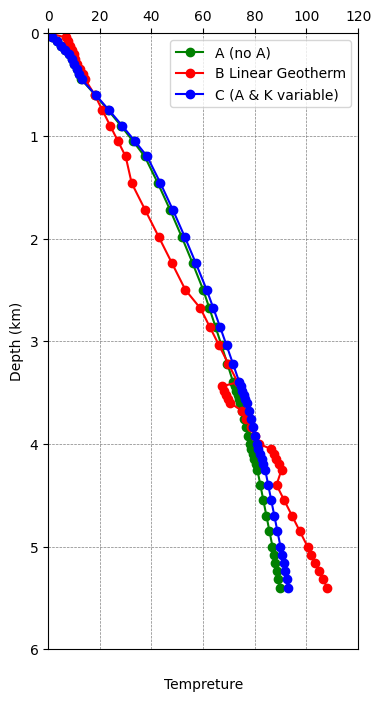

In [127]:
y = work_layers["Depth bottom, m"].tolist()
y_add = y.insert(0, 0)

print(Linear, y)

plt.figure(figsize=(4, 8))
plt.plot(A_line, y , label='A (no A)', marker='o', color='green')
# plt.plot(T_true['0'], y , label='McKenzie')
plt.plot(Linear, y , label='B Linear Geotherm', marker='o', color='red')
plt.plot(C_line, y , label='C (A & K variable)', marker='o', color='blue')


# plt.axis([np.round(max(age_values), -2), np.min(age_values), np.max(output_df)+0.5, 0])

plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
# plt.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)

# Move the x-axis label to the top
plt.xlabel(f'Tempreture', labelpad=20)
plt.ylabel(f'Depth (km)')
# plt.gca().xaxis.set_label_coords(0.5, 1.15)

plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.xlim(0, 120)
plt.ylim(0, 6)
plt.gca().invert_yaxis()
plt.show()

#### Plot: Geotherm

In [128]:
T0 = 0
Linear = T_linear_geotherm["0.0"].tolist()
Linear.insert(0, T0)


A_line = T_without_rad_heat["0.0"].tolist()
A_line.insert(0, T0)

C_line = T_with_rad_heat["0.0"].tolist()
C_line.insert(0, T0)

[0, 6.799999999999998, 7.599999999999989, 8.399999999999983, 9.200000000000003, 9.999999999999986, 10.35217391304345, 11.35217391304343, 12.352173913043437, 13.352173913043433, 14.35217391304343, 17.999999999999943, 20.999999999999957, 23.99999999999995, 26.99999999999997, 29.99999999999996, 32.33043478260866, 37.53043478260865, 42.73043478260867, 47.93043478260867, 53.13043478260867, 58.95217391304346, 62.552173913043454, 66.15217391304347, 69.75217391304345, 73.35217391304343, 67.19130434782605, 67.99130434782606, 68.79130434782606, 69.59130434782605, 70.39130434782605, 75.14782608695648, 76.7478260869565, 78.34782608695647, 79.94782608695647, 81.54782608695648, 86.35217391304343, 87.35217391304343, 88.35217391304343, 89.35217391304342, 90.3521739130434, 88.3999999999999, 91.39999999999989, 94.3999999999999, 97.39999999999989, 100.3999999999999, 101.59999999999991, 103.19999999999992, 104.79999999999991, 106.39999999999992, 107.99999999999994] [0, 0.04, 0.08, 0.12, 0.16, 0.2, 0.25, 0

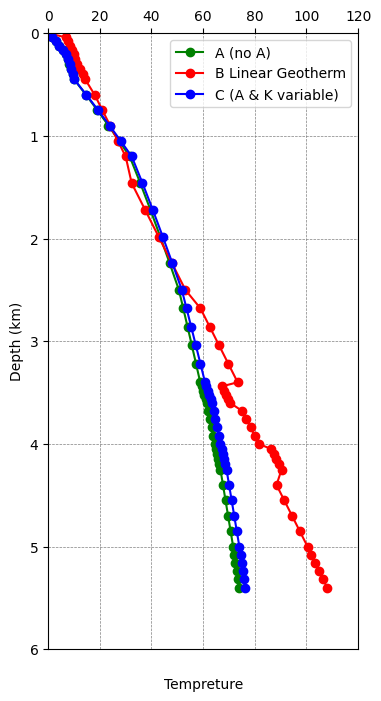

In [129]:
y = work_layers["Depth bottom, m"].tolist()
y_add = y.insert(0, 0)

print(Linear, y)

plt.figure(figsize=(4, 8))
plt.plot(A_line, y , label='A (no A)', marker='o', color='green')
# plt.plot(T_true['0'], y , label='McKenzie')
plt.plot(Linear, y , label='B Linear Geotherm', marker='o', color='red')
plt.plot(C_line, y , label='C (A & K variable)', marker='o', color='blue')


# plt.axis([np.round(max(age_values), -2), np.min(age_values), np.max(output_df)+0.5, 0])

plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
# plt.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)

# Move the x-axis label to the top
plt.xlabel(f'Tempreture', labelpad=20)
plt.ylabel(f'Depth (km)')
# plt.gca().xaxis.set_label_coords(0.5, 1.15)

plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.xlim(0, 120)
plt.ylim(0, 6)
plt.gca().invert_yaxis()
plt.show()

In [130]:
def makeplot(data1, data2, top_depth, bottom_depth):
    # fig = plt.figure(constrained_layout=True, figsize=(10, 6))
    # ax = fig.subplots(1, 2,  sharex=False)

    fig, ax = plt.subplots(figsize=(14,7))

    ax1 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,3), (0,1), rowspan=1, colspan = 1, sharey = ax1)
    ax3 = plt.subplot2grid((1,3), (0,2), rowspan=1, colspan = 1, sharey = ax1)

    # As our curve scales will be detached from the top of the track,
    # this code adds the top border back in without dealing with splines
    # ax10 = ax1.twiny()
    # ax10.xaxis.set_visible(False)

    # ax13 = ax4.twiny()
    # ax13.xaxis.set_visible(False)

### Plot 1
    # Geotherma
    T0 = 0

    x_values = data1['0.0'].tolist()
    x_values.insert(0, T0)
    y_values = decompaction_corrected_df['0.0'].tolist()
    y_values.insert(0, 0)
    ax1.plot(x_values, y_values, label='With radiation', marker='o', color='red')

    x_values = data2['0.0'].tolist()
    x_values.insert(0, T0)
    y_values = decompaction_corrected_df['0.0'].tolist()
    y_values.insert(0, 0)
    ax1.plot(x_values, y_values, label='Linear', marker='o', color='black')
    # ax1.plot(T_true['0'], decompaction_corrected_df['0'], label='McKenzie')

    ax1.set_xlabel(f'Tempreture', labelpad=20)
    ax1.set_ylabel(f'Depth (km)')
    ax1.legend()
    ax1.set_xlim([0, 120])

### Plot 2
    # Lithology track
    # ax2.plot(T_with_rad_heat["Lithology"], T_with_rad_heat['depth 0'], color = "black", linewidth = 0.5)
    ax2.set_xlabel("Lithology")
    ax2.set_xlim(0, 1)
    ax2.xaxis.label.set_color("black")
    ax2.tick_params(axis='x', colors="black")
    ax2.spines["top"].set_edgecolor("black")
    ax2.set_xticks([0, 1])

    depth_start = 0

    for lit, depth in zip(work_layers_with_color.index, decompaction_corrected_df['0.0']):
        key = int(lit)
        color = work_layers_with_color.at[lit, 'Color']
        hatch = work_layers_with_color.at[lit, 'Index']

        depth_values = [depth_start, depth]
        depth_start = depth

        ax2.fill_betweenx(depth_values, 0, 1, facecolor=color, hatch=hatch)

    ax2.set_xticks([0, 1])

### Plot3
    ax3.set_xlabel("Lithology")
    ax3.set_xlim(0, 1)
    ax3.xaxis.label.set_color("black")
    ax3.tick_params(axis='x', colors="black")
    ax3.spines["top"].set_edgecolor("black")
    ax3.set_xticks([0, 1])

    depth_start = 0

    for lit, depth in zip(work_layers_with_color['Lithology_type'], decompaction_corrected_df['0.0']):
        key = lit
        depth_values = [depth_start, depth]
        depth_start = depth

        label_position = (0.5, sum(depth_values) / 2)  # Assuming x position is at 0.5
        ax3.text(label_position[0], label_position[1], key, ha='center', va='center')
        ax3.plot([0, 1], [depth, depth], color='black', linewidth=1)  # Assuming black color and linewidth of 1



    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(bottom_depth, top_depth)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))

    for ax in [ax2]:
        plt.setp(ax.get_yticklabels(), visible = False)

    plt.tight_layout()
    fig.subplots_adjust(wspace = 0.15)

In [136]:
temperature = pd.read_csv('/content/Geotherm_SG', skiprows=0, header=0)
linear_temperature = pd.read_csv('/content/Linear_Geotherm', skiprows=0, header=0)

makeplot(temperature, # данные 1: геотерма с изменяюшимся ТС и Радиацией
         linear_temperature,  # данные 2: линейная геотерма
         0, max(decompaction_corrected_df['0.0']))

NameError: name 'linear_temperature' is not defined

### Plot: Paleotemperature

[0.0, 9.0, 18.0, 27.0, 36.0, 45.0, 47.0, 49.0, 51.0, 53.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 84.0, 88.0, 92.0, 96.0, 100.0, 105.0, 110.0, 115.0, 120.0, 125.0, 129.0, 133.0, 137.0, 141.0, 145.0, 148.0, 151.0, 154.0, 157.0, 160.0, 170.0, 180.0, 190.0, 200.0, 210.0, 220.0, 230.0, 240.0, 250.0, 245.0, 248.0, 251.0, 254.0, 257.0]


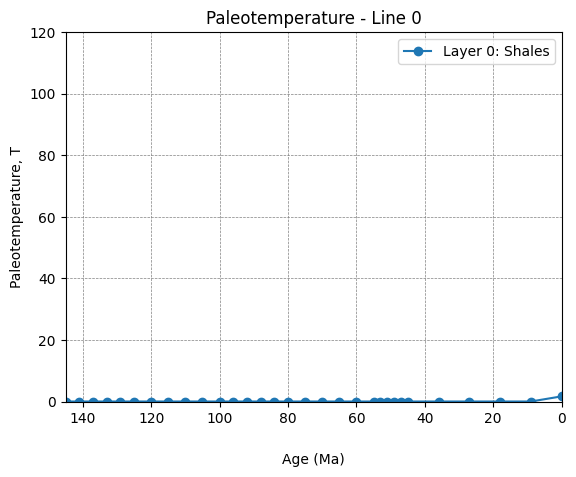

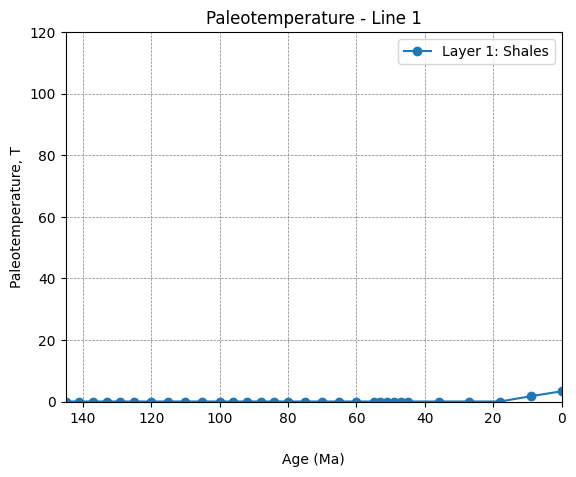

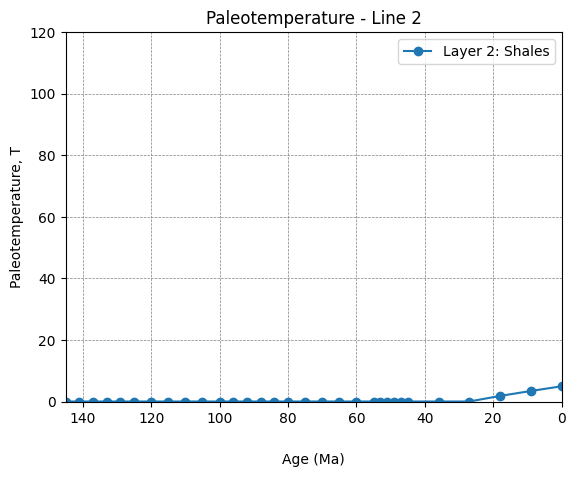

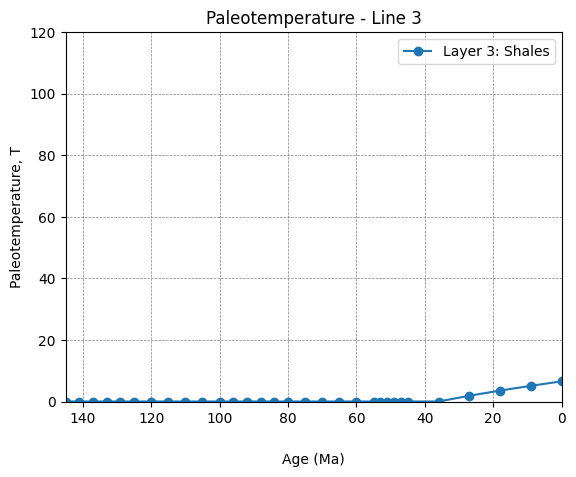

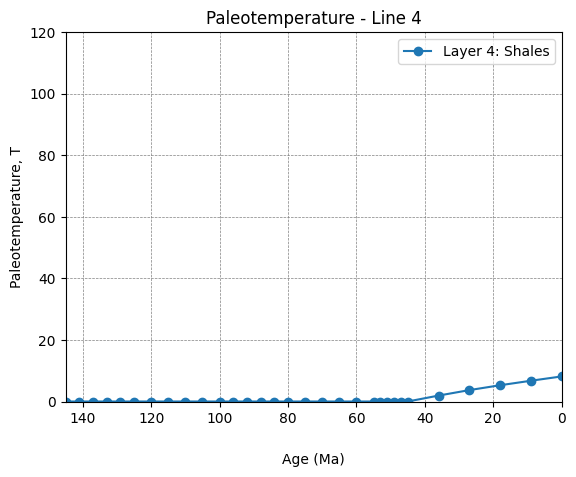

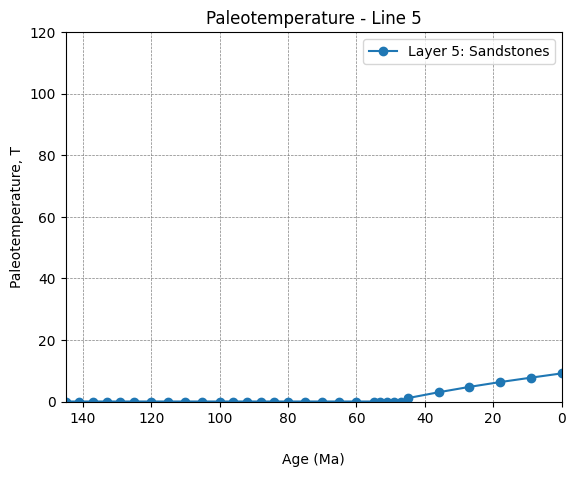

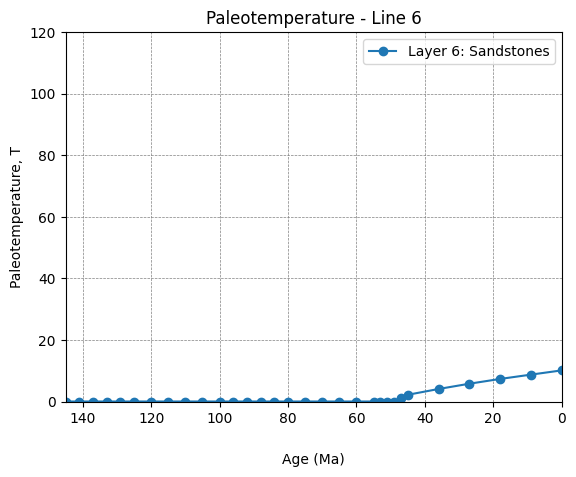

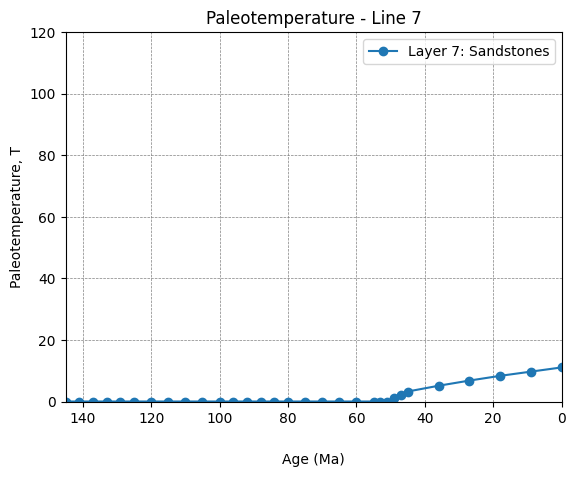

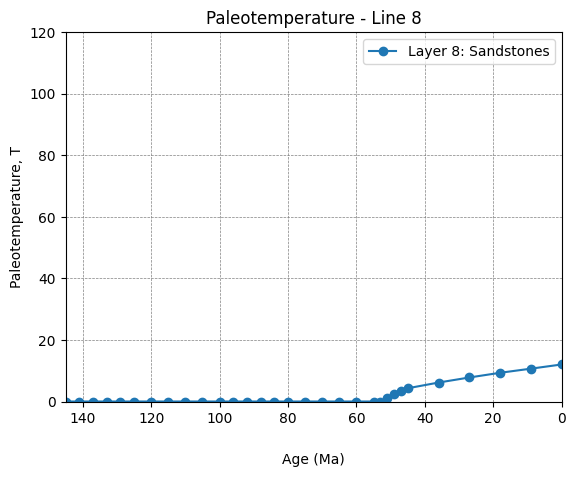

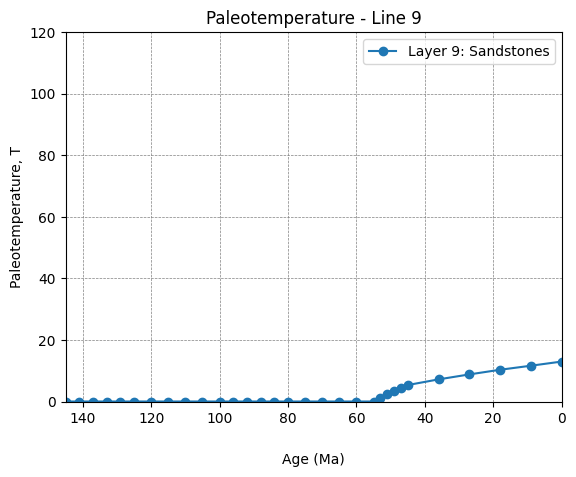

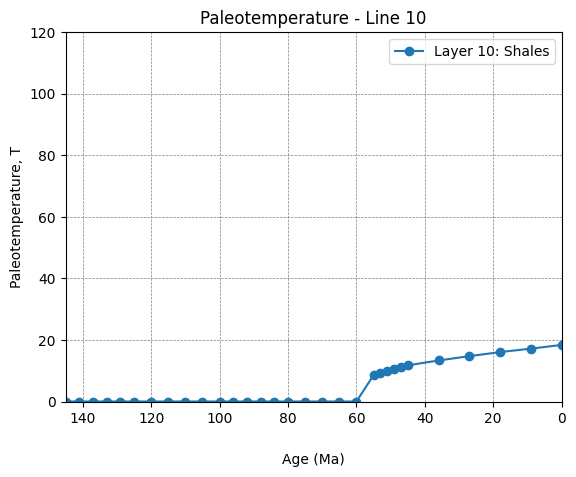

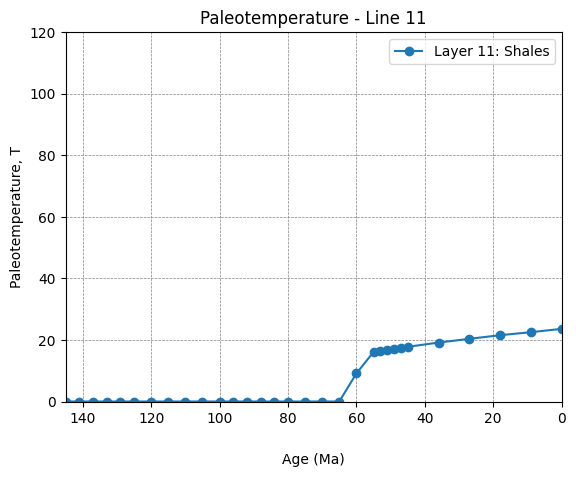

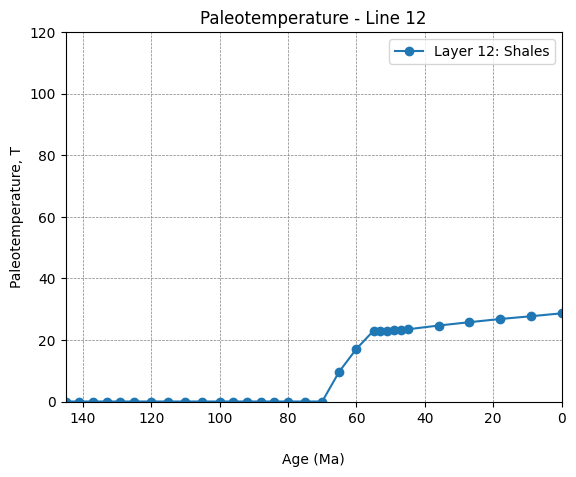

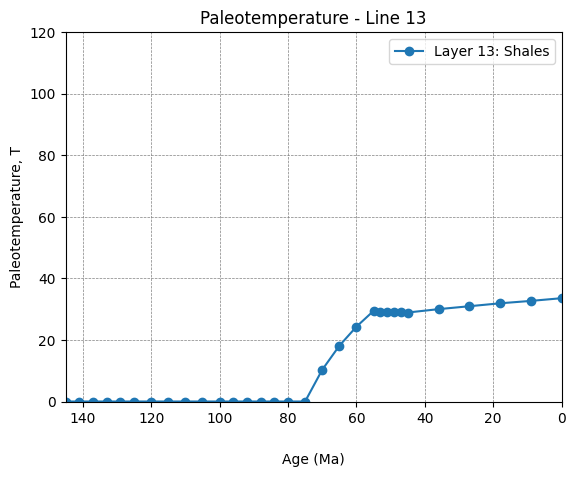

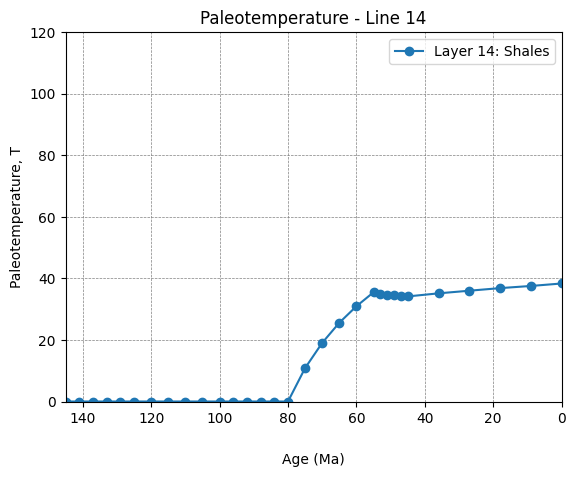

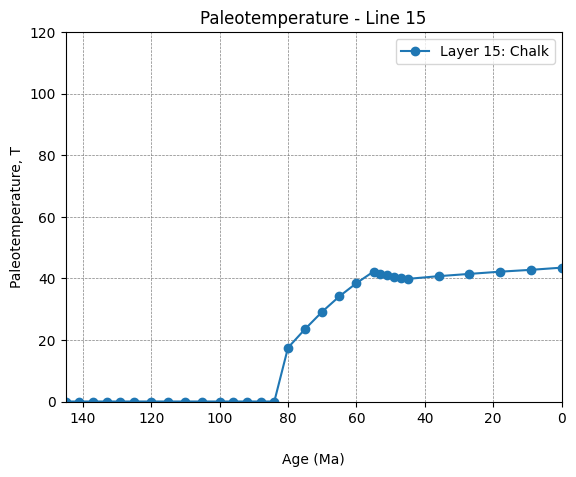

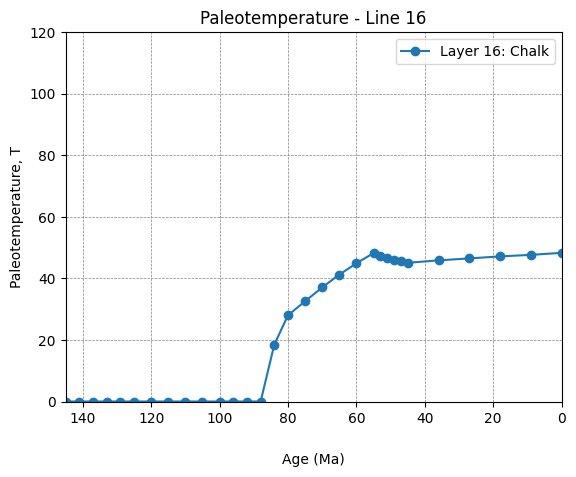

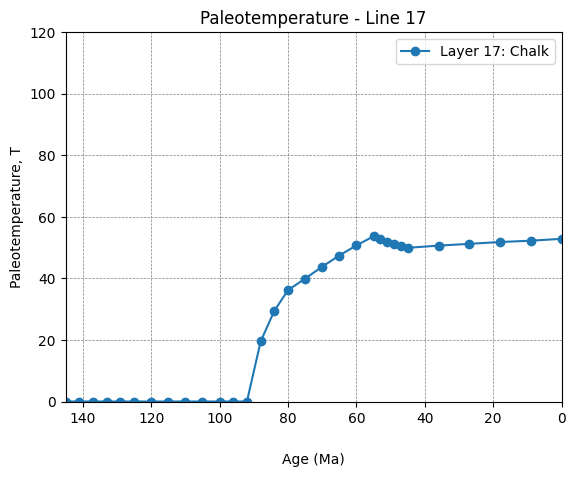

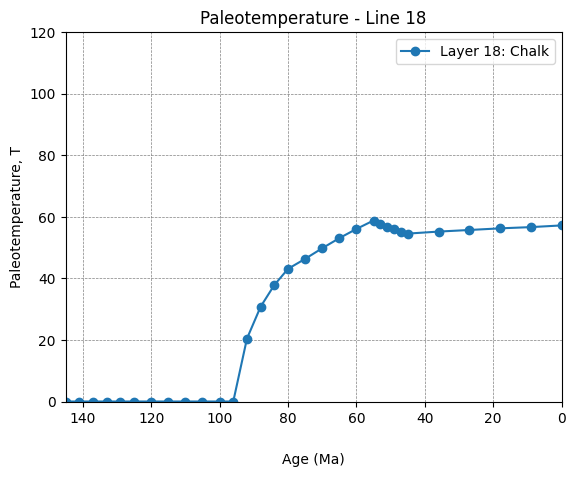

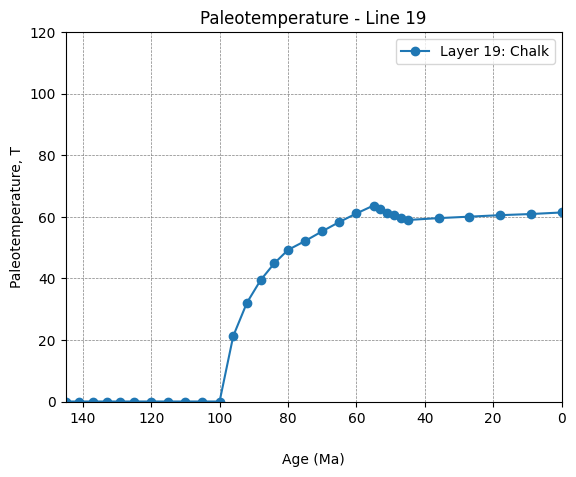

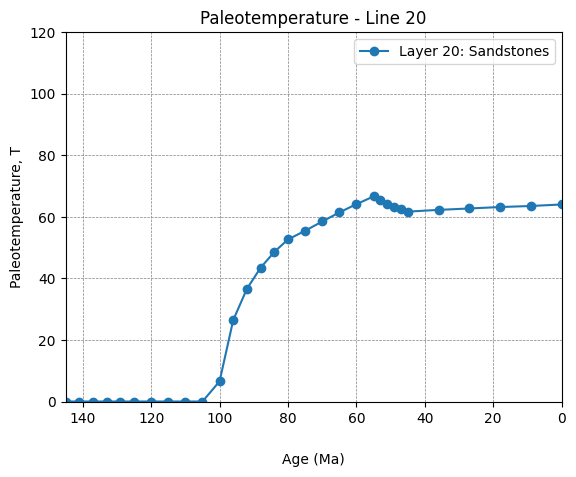

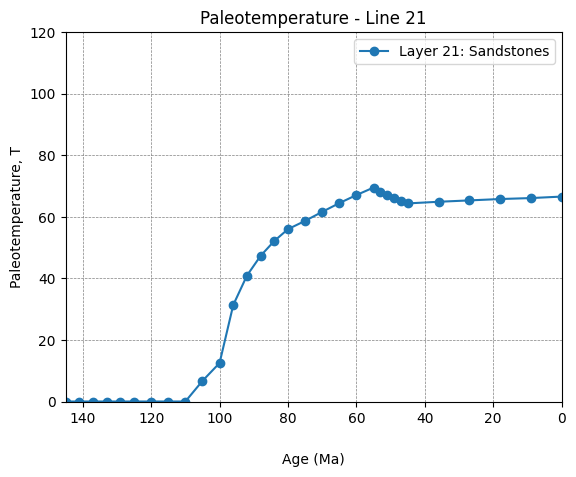

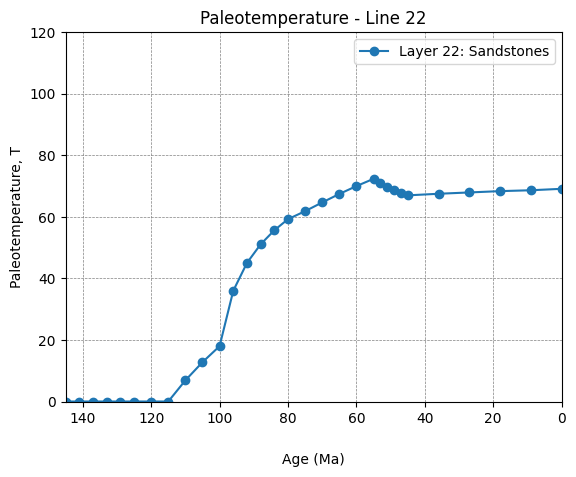

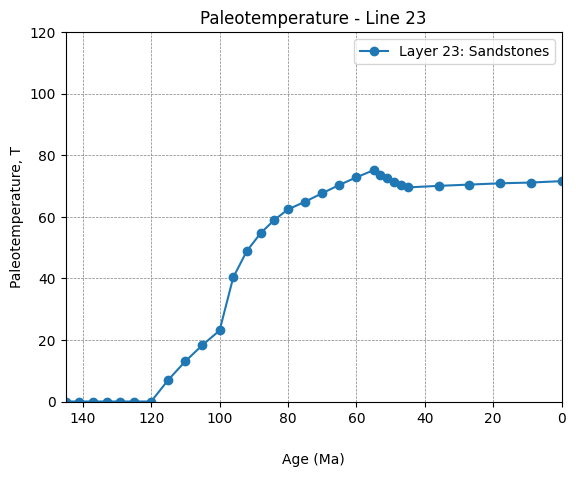

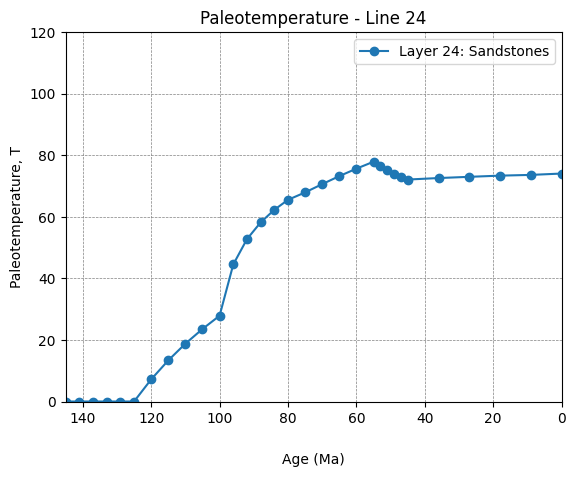

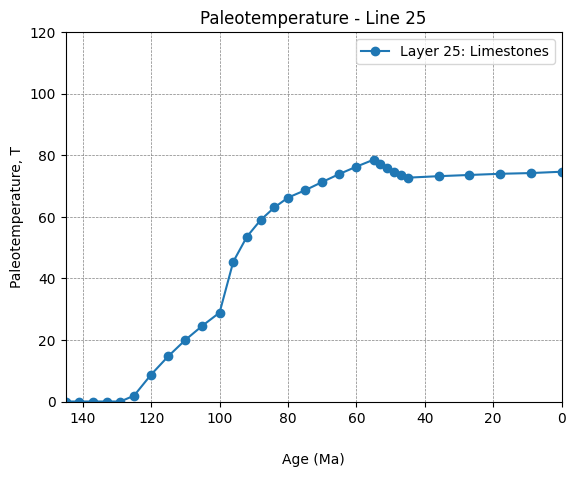

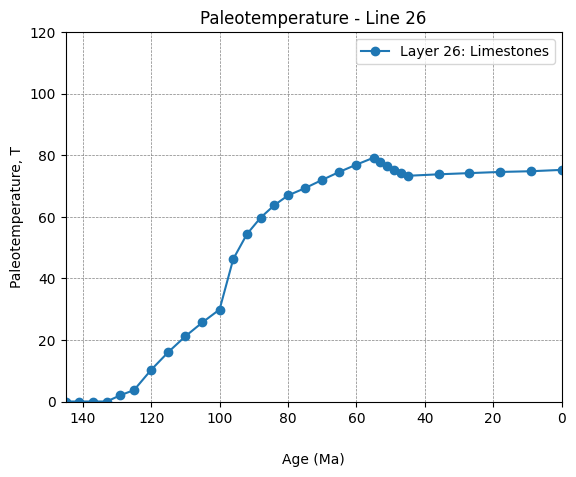

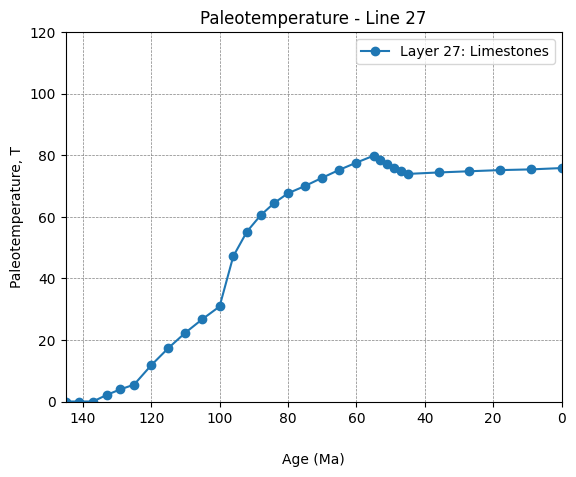

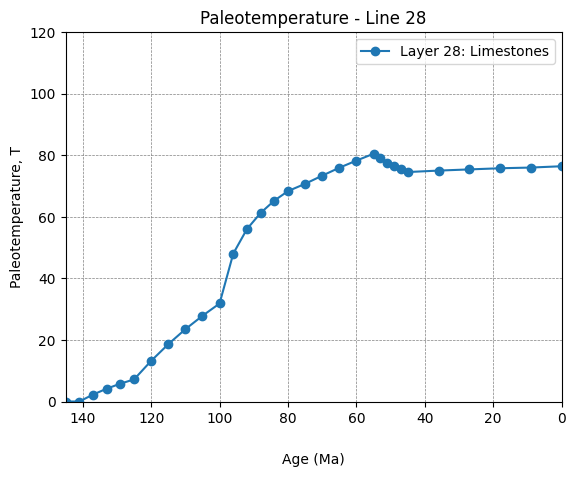

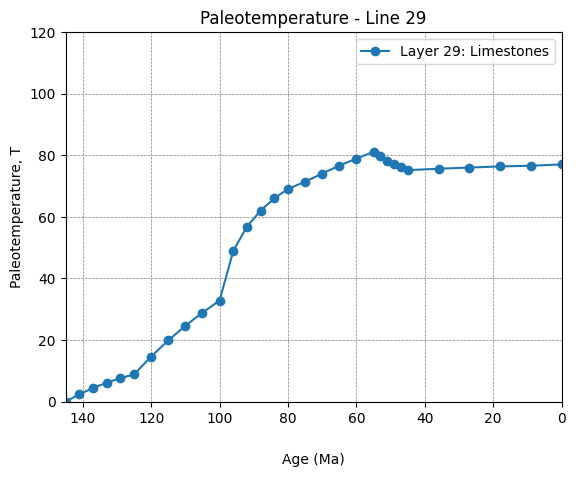

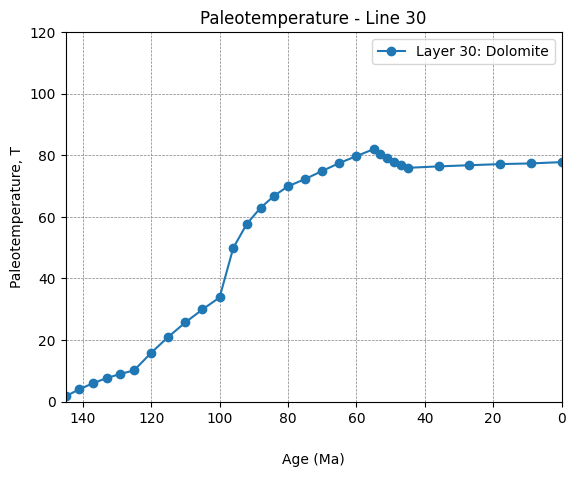

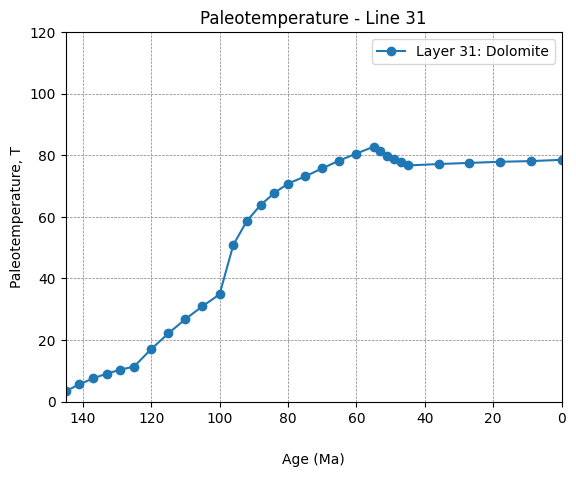

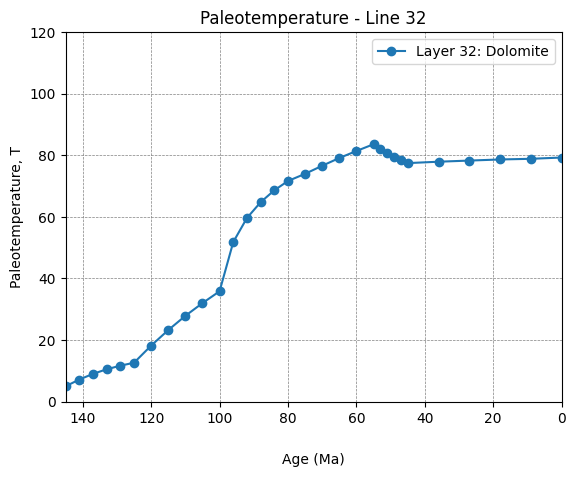

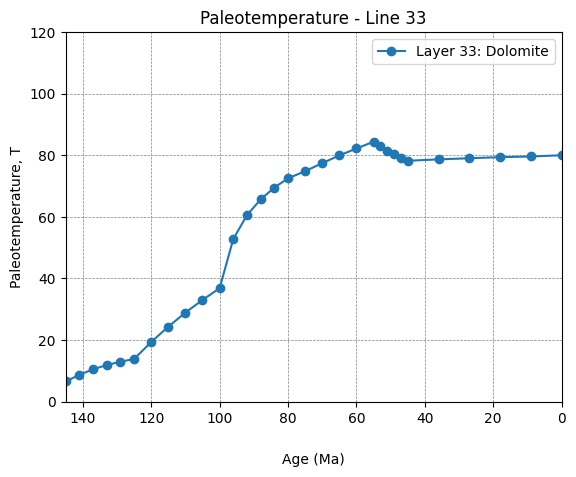

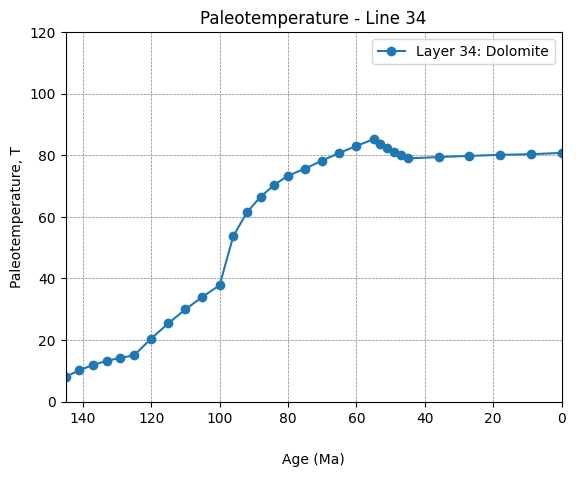

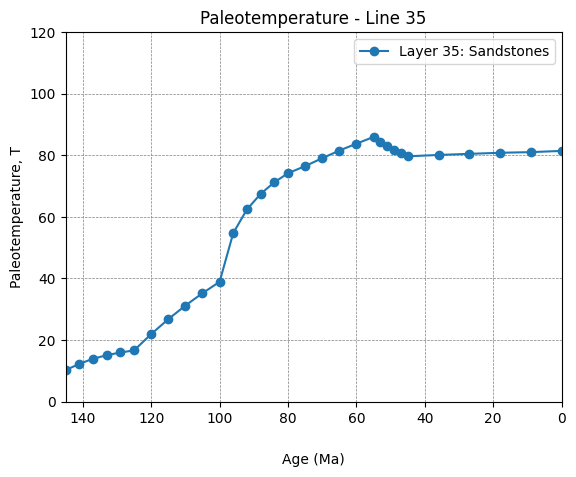

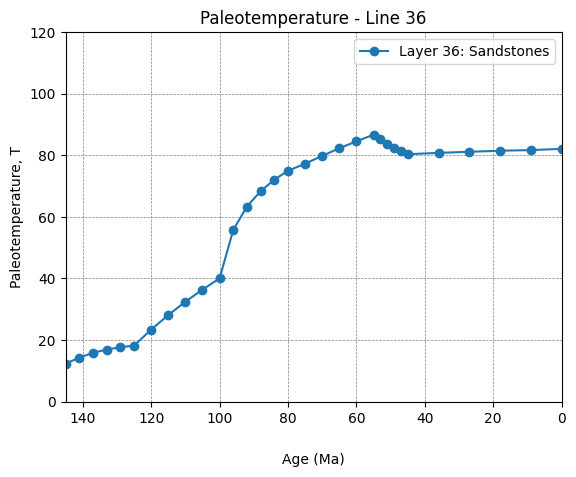

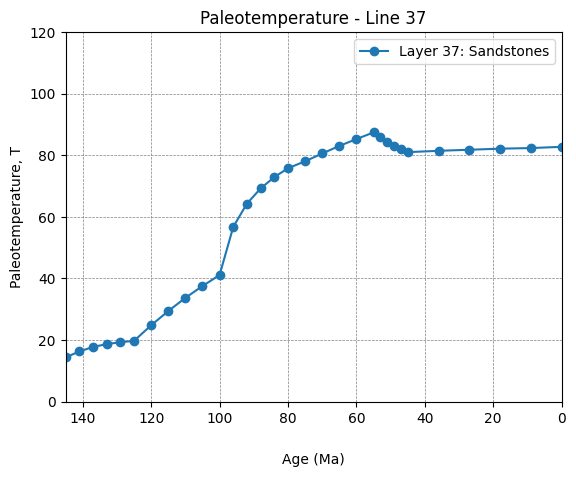

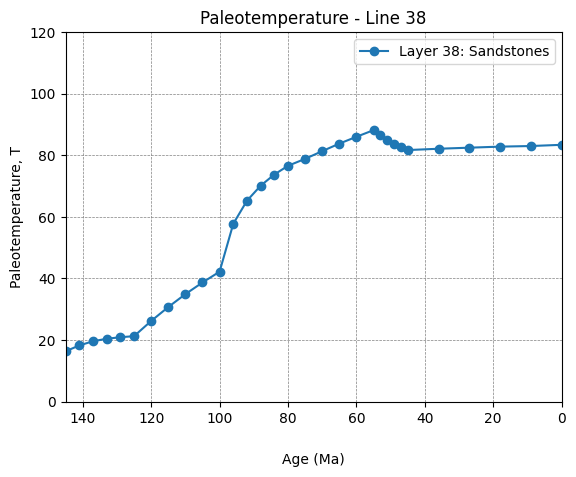

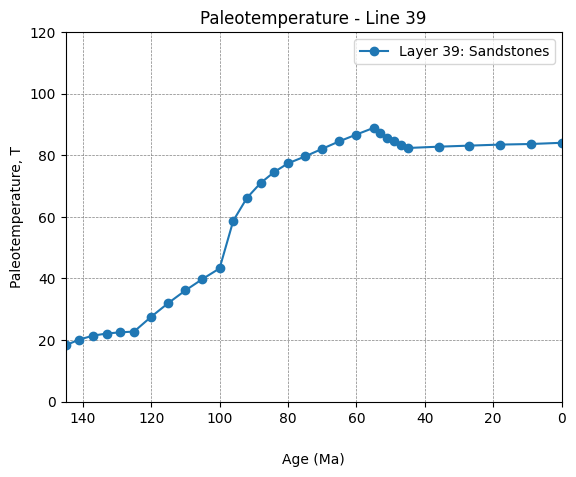

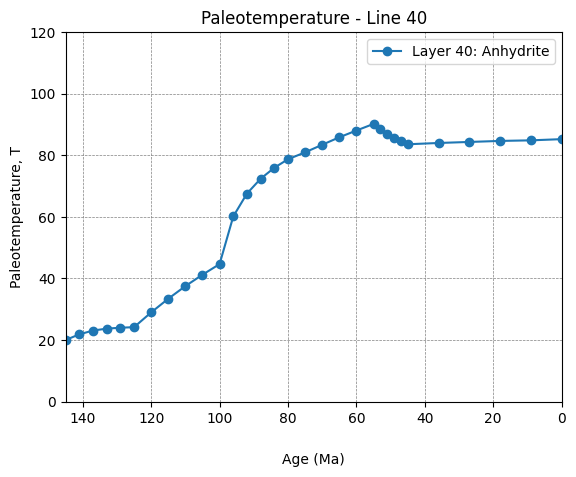

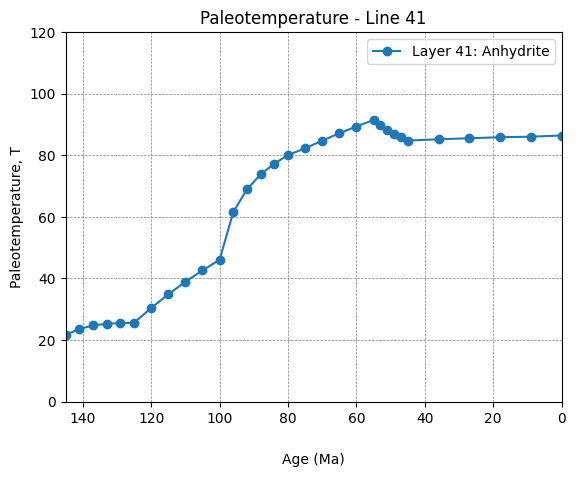

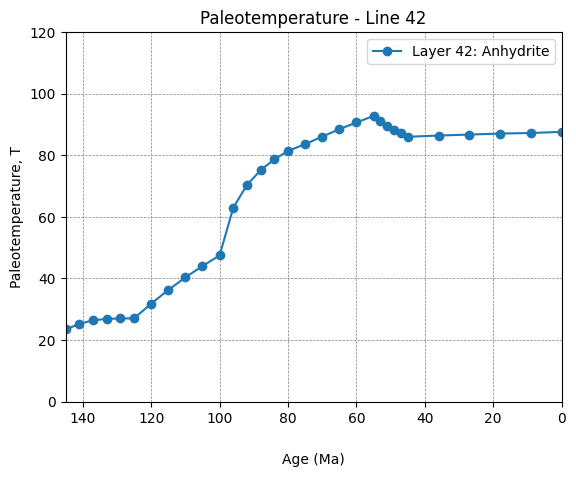

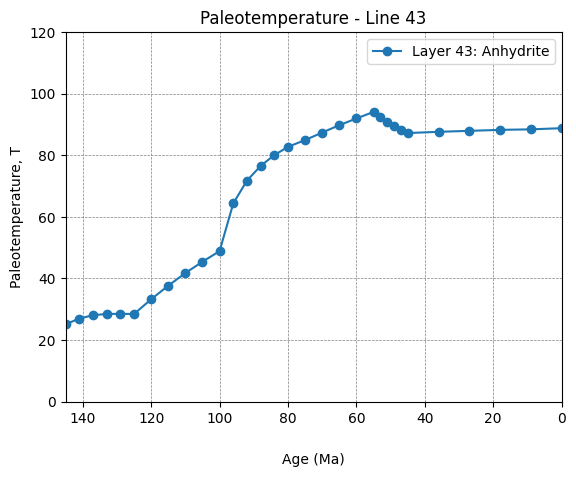

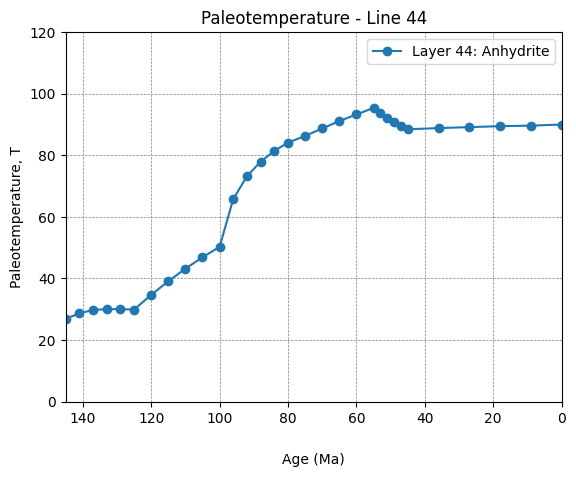

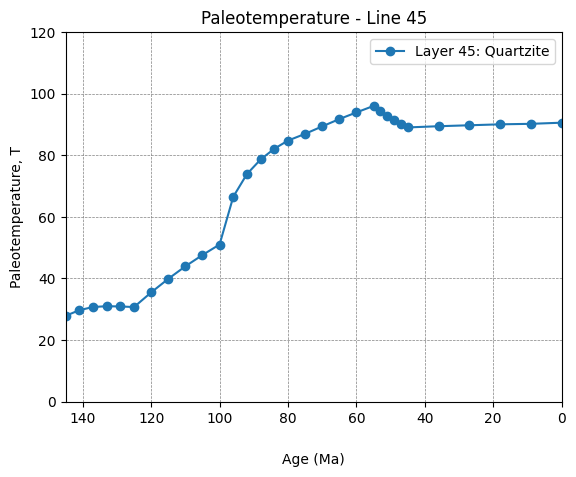

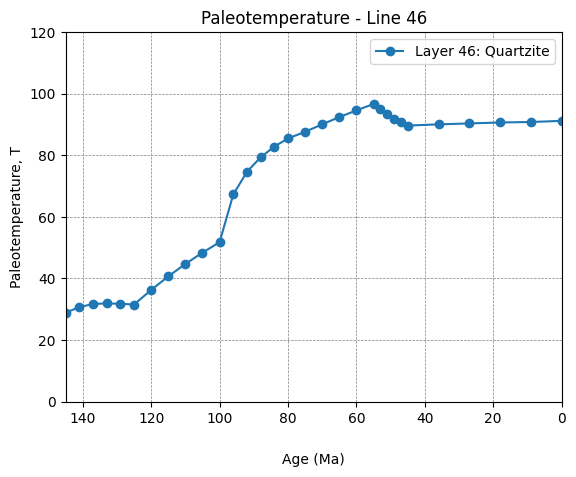

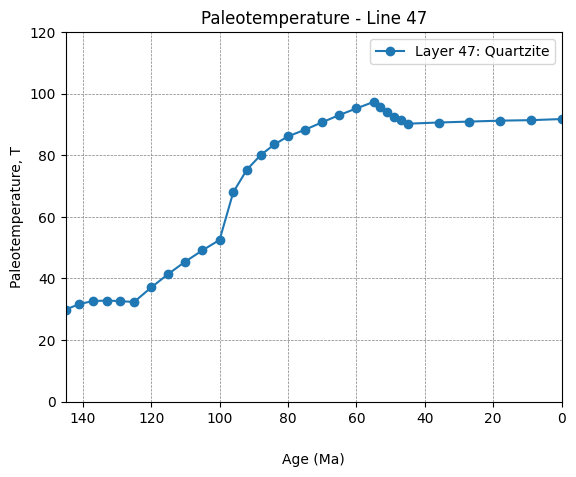

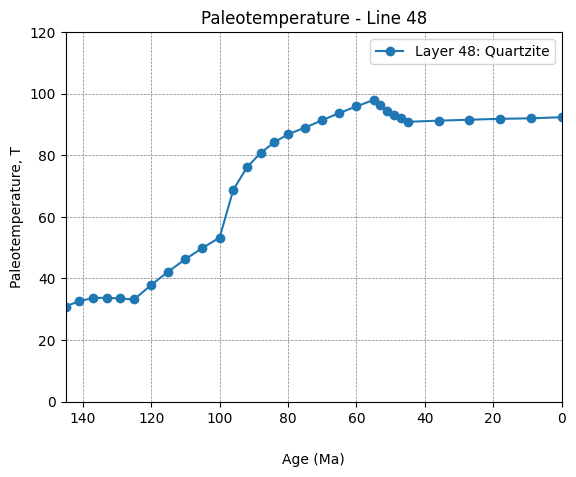

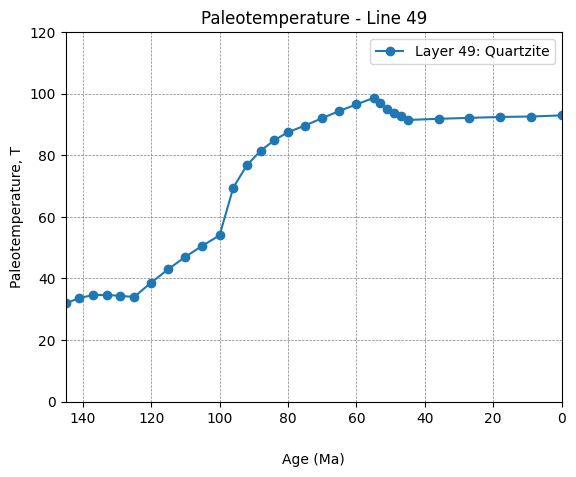

In [132]:
# age_values = [float(age) for age in work_layers['Age (Ma)'][0:]]

# values_for_plot = pd.read_csv('/content/Geotherm_with_A', skiprows=0, header=0)
values_for_plot = pd.read_csv('/content/Geotherm_SG', skiprows=0, header=0)

age_values = values_for_plot.iloc[0:, 3:values_for_plot.shape[1]].columns.astype(float).tolist()[::-1]
print(age_values)

for row_index, row in values_for_plot.iloc[0:, 3:values_for_plot.shape[1]].iterrows():
    plt.figure()  # Create a new figure for each row
    lithology = values_for_plot["Lithology_type"][row_index]
    plt.plot(age_values, row[::-1], label= "Layer "+ str(row_index) + ": "+ str(lithology), marker='o')
    plt.xlabel('Age (Ma)', labelpad=20)
    plt.ylabel('Paleotemperature, T')
    plt.legend()
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.xlim(0, 145)
    plt.ylim(0, 120)
    plt.gca().invert_xaxis()
    plt.title(f"Paleotemperature - Line {row_index}")
    plt.show()

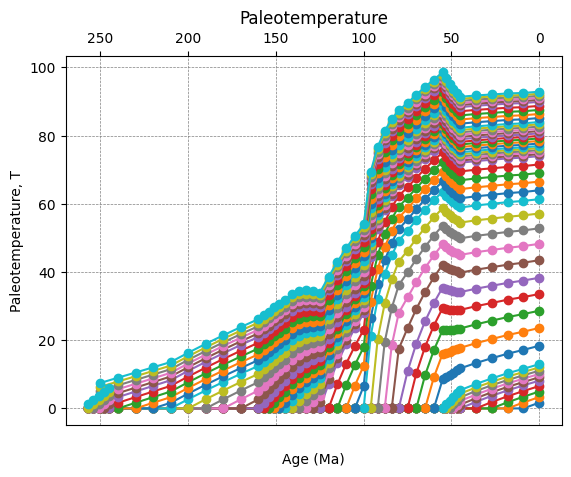

In [134]:
# age_values  = [int(age) for age in work_layers['Age (Ma)'][0:]]
# print(age_values )
# print(age_values[::-1])

values_for_plot = pd.read_csv('/content/Geotherm_SG',
                              skiprows=0, header=0)

age_values = values_for_plot.iloc[0:, 3:values_for_plot.shape[1]].columns.astype(float).tolist()[::-1]
for row_index, row in values_for_plot.iloc[0:, 3:values_for_plot.shape[1]].iterrows():
  plt.plot(age_values, row[::-1], label=str(row_index), marker='o')

# Move the x-axis label to the top
plt.xlabel('Age (Ma)', labelpad=20)
plt.ylabel('Paleotemperature, T')

# Adjust tick parameters
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelright=False)

# plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# plt.xlim(0, 145)
plt.gca().invert_xaxis()
plt.title("Paleotemperature")


# Display the plot
plt.show()